# Comparison of 2 Traffic Sign Detection models based on the German Traffic Sign Detection Benchmark (GTSDB)

# Plan

1. Introduction and Problem Statement
2. Setup and Environment Preparation
3. Function Definitions
   - 3.1 Data loading functions
   - 3.2 Data splitting functions
   - 3.3 Dataset preparation functions
   - 3.4 Model training functions
   - 3.5 Evaluation functions
4. Data Loading
5. Data Exploration
6. Data Splitting and Preparation (applying the functions)
7. Model Training - YOLO
8. Model Training - RT-DETR
9. Model Evaluation and Conclusion

#1. Introduction and Problem Statement




*   Traffic sign detection is a critical component of intelligent transportation systems, autonomous vehicles, and advanced driver assistance systems, with direct implications for road safety.
*   This project leverages the German Traffic Sign Detection Benchmark (GTSDB) dataset, containing 900 real-world images of traffic signs in various driving conditions.
*   Traffic sign detection presents unique challenges including significant size variations, dramatic lighting differences, partial occlusions, and natural class imbalance where some sign types appear much more frequently than others.
*   We implement and compare two different model architectures:
   - YOLOv8-large: A traditional CNN-based approach known for efficiency and speed
   - RT-DETR: A transformer-encoder-decoder architecture offering potentially better performance for complex detection scenarios
*   Our approach uses a 2-tier data handling strategy:
   - Standard classes: Common signs with ample examples for robust training (this notebook)
   - Few-shot classes: Less common signs with limited examples, requiring specialized techniques (separate notebook)

#2. Setup and Environment Preparation

*   **Environment Setup**: Imported essential data science and computer vision libraries (NumPy, pandas, OpenCV, matplotlib), deep learning frameworks (PyTorch, Ultralytics), and mounted Google Drive for data storage. Images were pre-converted from .ppm to .png format for compatibility.
*   **Data Configuration**: Established paths to annotations and images, defined mapping between traffic sign class IDs and their descriptions (43 classes total), and set global parameters (standard class threshold x=13, image sizes for each model architecture).

In [ ]:
# Import necessary libraries
import locale
locale.getpreferredencoding = lambda: 'UTF-8'

In [ ]:
#!pip install -U openmim
#!mim install mmcv-full

!pip install tqdm
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# ================= Standard Libraries =================
import os
import glob
import random
import shutil
import time
from collections import Counter, defaultdict
from pathlib import Path
from typing import List, Dict

# ================= Third-Party Libraries =================
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from google.colab import drive
from matplotlib.patches import Patch
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from ultralytics import YOLO, RTDETR

# Mount Google Drive (Colab-specific)
drive.mount('/content/drive', force_remount=True)

# -----------------------------------------------------------------------------------------------------------------------------

# Define mapping of class IDs to descriptions and categories (based on ReadMe.txt)
class_info = {
    0: ("Speed limit 20", "prohibitory"),
    1: ("Speed limit 30", "prohibitory"),
    2: ("Speed limit 50", "prohibitory"),
    3: ("Speed limit 60", "prohibitory"),
    4: ("Speed limit 70", "prohibitory"),
    5: ("Speed limit 80", "prohibitory"),
    6: ("Restriction ends 80", "other"),
    7: ("Speed limit 100", "prohibitory"),
    8: ("Speed limit 120", "prohibitory"),
    9: ("No overtaking", "prohibitory"),
    10: ("No overtaking (trucks)", "prohibitory"),
    11: ("Priority at next intersection", "danger"),
    12: ("Priority road", "other"),
    13: ("Give way", "other"),
    14: ("Stop", "other"),
    15: ("No traffic both ways", "prohibitory"),
    16: ("No trucks", "prohibitory"),
    17: ("No entry", "other"),
    18: ("Danger", "danger"),
    19: ("Bend left", "danger"),
    20: ("Bend right", "danger"),
    21: ("Bend", "danger"),
    22: ("Uneven road", "danger"),
    23: ("Slippery road", "danger"),
    24: ("Road narrows", "danger"),
    25: ("Construction", "danger"),
    26: ("Traffic signal", "danger"),
    27: ("Pedestrian crossing", "danger"),
    28: ("School crossing", "danger"),
    29: ("Cycles crossing", "danger"),
    30: ("Snow", "danger"),
    31: ("Animals", "danger"),
    32: ("Restriction ends", "other"),
    33: ("Go right", "mandatory"),
    34: ("Go left", "mandatory"),
    35: ("Go straight", "mandatory"),
    36: ("Go right or straight", "mandatory"),
    37: ("Go left or straight", "mandatory"),
    38: ("Keep right", "mandatory"),
    39: ("Keep left", "mandatory"),
    40: ("Roundabout", "mandatory"),
    41: ("Restriction ends (overtaking)", "other"),
    42: ("Restriction ends (overtaking trucks)", "other")
}

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [ ]:
# Define paths
base_path = "/content/drive/My Drive"
annotations_path = os.path.join(base_path, "annotations/gt.txt")
converted_path = os.path.join(base_path, "convert_images")

In [ ]:
# Global Configuration Settings
x = 13 # Standard class / Few shot learning threshold

INCLUDE_STANDARD_DATA = True
INCLUDE_FEW_SHOT_CLASSES = []

#3. Function Definitions

## 3.1 Data loading functions

*   **Class ID Conversion**: Creates a simple mapping system to convert traffic sign classes into sequential numeric IDs (starting from 0), required for compatibility with Ultralytics and other deep learning frameworks.
*   **Dataset Categorization**: Analyzes the frequency distribution of traffic sign classes, automatically separating them into "standard" classes (with sufficient examples) and "few-shot" classes (with limited examples) based on configurable thresholds (here, we use 13).
*   **Selective Data Loading**: Loads and processes only the relevant traffic sign annotations based on configuration parameters, converting coordinates and applying class mappings to create structured datasets ready for splitting into train/validation/test sets.

In [ ]:
# LabelMapper class
class LabelMapper:
    def __init__(self):
        self.label_to_id = {}
        self.id_to_label = {}

    def fit(self, classes):
        self.label_to_id = {label: idx for idx, label in enumerate(classes)}
        self.id_to_label = {idx: label for label, idx in self.label_to_id.items()}

    def transform(self, labels):
        # Handle both single values and lists
        if isinstance(labels, (list, tuple, np.ndarray)):  # Check if iterable
            return [self.label_to_id[label] for label in labels]
        else:  # Single value
            return self.label_to_id[labels]

    def inverse_transform(self, ids):
        # Handle both single values and lists
        if isinstance(ids, (list, tuple, np.ndarray)):
            return [self.id_to_label[id] for id in ids]
        else:
            return self.id_to_label[ids]

In [ ]:
def load_dataset_parameterized(x=x):
    """
    Load dataset with mapping to sequential IDs for included classes.
    Returns: (standard_data, few_shot_data, mapper)
    """
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    # First pass: Class analysis
    class_counts = defaultdict(int)
    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) == 6:
            class_counts[int(parts[5])] += 1

    # Categorize classes
    standard_classes = [c for c, cnt in class_counts.items() if cnt >= x]
    few_shot_classes = [c for c, cnt in class_counts.items() if cnt < x]

    # Determine included classes
    included_classes = []
    if INCLUDE_STANDARD_DATA:
        included_classes.extend(standard_classes)
    if INCLUDE_FEW_SHOT_CLASSES:
        included_classes.extend([c for c in few_shot_classes
                               if c in INCLUDE_FEW_SHOT_CLASSES or str(c) in INCLUDE_FEW_SHOT_CLASSES])

    # Create mapper for included classes - using sorted to ensure consistent mapping
    mapper = LabelMapper()
    mapper.fit(sorted(included_classes))

    # Second pass: Build datasets with mapping
    standard_data, few_shot_data = [], []
    processed_images = set()

    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) != 6:
            continue

        img_file = parts[0]
        coords = [int(parts[i]) for i in range(1, 5)]
        original_class = int(parts[5])

        # Skip classes not in included set
        if original_class not in included_classes:
            continue

        # Create mapped annotation
        annotation = {
            'img_path': os.path.join(converted_path, img_file.replace('.ppm', '.png')),
            'bbox': coords,
            'original_class': original_class,
            'class_id': mapper.transform(original_class)  # Sequential ID
        }

        # Categorize based on original class counts
        if original_class in standard_classes:
            standard_data.append(annotation)
        else:
            few_shot_data.append(annotation)

        processed_images.add(annotation['img_path'])

    print(f"Class Mapping: {mapper.label_to_id}")
    return standard_data, few_shot_data, mapper

## 3.2 Data splitting functions

*   **Image-Level Stratification**: Splits data into 60% training, 10% validation, and 30% test sets at the image level (not annotation level), using the dominant traffic sign class in each image to ensure proportional representation across all splits.
*   **Leakage Prevention**: Maintains data integrity by ensuring all annotations from the same image stay together in one split, preventing the same scene from appearing in both training and evaluation sets.
*   **Class-Aware Splitting**: Preserves the distribution of traffic sign classes across all splits through stratified sampling, ensuring rare classes are proportionally represented in training, validation, and test sets.
*   **Configurable Selection**: Processes only the specified classes (standard classes by default, with optional few-shot classes) based on the configuration parameters set at the beginning of the notebook.

In [ ]:
# Data Splitting and Preparation : create_stratified_split
def create_stratified_split(data, val_ratio=0.10, test_ratio=0.30, seed=None):
    """
    Creates stratified splits at the IMAGE LEVEL while preserving class distribution.

    Key Features:
    - Operates on images (not individual annotations)
    - Uses majority class per image for stratification
    - Automatically maintains original annotation structure
    - Pure numpy/sklearn implementation (no torch dependency)
    """

    # 1. Group annotations by image and find dominant class
    image_groups = defaultdict(list)
    for anno in data:
        image_groups[anno['img_path']].append(anno)

    # 2. Prepare stratified split inputs
    image_paths, dominant_classes = [], []
    for path, annos in image_groups.items():
        class_counts = defaultdict(int)
        for a in annos:
            class_counts[a['class_id']] += 1
        dominant_classes.append(max(class_counts, key=class_counts.get))
        image_paths.append(path)

    X = np.array(image_paths)
    y = np.array(dominant_classes)

    # 3. Calculate absolute sample sizes
    n_total = len(X)
    n_test = int(n_total * test_ratio)
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_test - n_val

    # 4. Create splits
    splitter = StratifiedShuffleSplit(n_splits=1,
                                    test_size=n_test + n_val,
                                    random_state=seed)
    train_idx, temp_idx = next(splitter.split(X, y))

    # Split temp into val/test
    splitter_temp = StratifiedShuffleSplit(n_splits=1,
                                         test_size=n_test/(n_test + n_val),
                                         random_state=seed)
    val_idx, test_idx = next(splitter_temp.split(X[temp_idx], y[temp_idx]))

    # 5. Map back to annotations
    def get_split(indices):
        return [anno for i in indices for anno in image_groups[X[i]]]

    return (
        get_split(train_idx),
        get_split(temp_idx[val_idx]),
        get_split(temp_idx[test_idx])
    )

## 3.3 Dataset preparation functions

*   **Ultralytics Format Conversion**: Transforms data into the Ultralytics-compatible format (used by both YOLO and RT-DETR models) by creating structured directories and converting bounding boxes from absolute coordinates to normalized format (center_x, center_y, width, height).
*   **Configuration File Generation**: Creates a dataset configuration file in YAML format (a human-readable data format) that defines dataset paths and class mappings required by both YOLO and RT-DETR models, establishing a unified interface for different model architectures.

In [ ]:
def prepare_ultralytics_dataset(data_list, output_dir):
    """
    Prepare dataset in YOLO format for Ultralytics models (works for both YOLO and DETR)

    Args:
        data_list: List of dictionaries containing image data
        output_dir: Directory to save prepared dataset
    """
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for idx, item in tqdm(enumerate(data_list), total=len(data_list),
                         desc=f"Preparing {os.path.basename(output_dir)}"):
        # Link or copy image
        img_path = item['img_path']
        img_filename = f"{idx:05d}.jpg"
        new_img_path = os.path.join(images_dir, img_filename)

        if os.path.exists(img_path) and not os.path.exists(new_img_path):
            try:
                os.symlink(os.path.abspath(img_path), new_img_path)
            except:
                shutil.copy(img_path, new_img_path)

        # Get image dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Cannot read image {img_path}")
            continue

        h, w = img.shape[:2]

        # Convert bbox to YOLO format
        x1, y1, x2, y2 = item['bbox']
        x_center = ((x1 + x2) / 2) / w
        y_center = ((y1 + y2) / 2) / h
        width = (x2 - x1) / w
        height = (y2 - y1) / h

        # Write label file
        with open(os.path.join(labels_dir, f"{idx:05d}.txt"), 'w') as f:
            f.write(f"{item['class_id']} {x_center} {y_center} {width} {height}\n")

In [ ]:
def setup_dataset(train_data, val_data, test_data, mapper):
    """
    Set up the entire dataset for Ultralytics models

    Args:
        train_data: Training data list
        val_data: Validation data list
        test_data: Test data list
        mapper: Object mapping between class IDs and labels

    Returns:
        str: Path to the YAML configuration file
    """
    # Set up data directory
    data_dir = os.path.join(os.getcwd(), "traffic_sign_data")
    os.makedirs(data_dir, exist_ok=True)

    # Export datasets to Ultralytics format
    print("\nPreparing datasets for Ultralytics...")
    prepare_ultralytics_dataset(train_data, os.path.join(data_dir, "train"))
    prepare_ultralytics_dataset(val_data, os.path.join(data_dir, "val"))
    prepare_ultralytics_dataset(test_data, os.path.join(data_dir, "test"))

    # Create YAML config
    yaml_path = os.path.join(data_dir, "dataset.yaml")
    class_names = {i: f"class_{mapper.id_to_label[i]}" for i in range(len(mapper.id_to_label))}

    yaml_content = {
        "path": data_dir,
        "train": os.path.join(data_dir, "train/images"),
        "val": os.path.join(data_dir, "val/images"),
        "test": os.path.join(data_dir, "test/images"),
        "names": class_names
    }

    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"Created dataset configuration at {yaml_path}")

    return yaml_path

## 3.4 Model training functions

*   **Enhanced YOLO Training**: Implements a comprehensive augmentation strategy for YOLOv8x with carefully balanced transformations - aggressive geometric augmentations (rotation, scaling, shearing) combined with controlled color adjustments to preserve sign recognizability, plus advanced techniques (mosaic, mixup, copy-paste) that create one augmented version per original image.
*   **Conservative RT-DETR Training**: Employs minimal, traffic sign-safe augmentations with the RT-DETR model - using larger image size (800px vs 640px) with only slight hue adjustments while completely disabling perspective transformations to preserve traffic sign appearance and proportions, also creating one augmented version per image per epoch (Ultralytics default behavior).
*   **Adaptive Evaluation Visualization**: Creates comprehensive multi-panel visualizations that automatically detect and display appropriate metrics (mAP, precision/recall, loss components) for both model types, enabling performance comparison across different architectures and training approaches while tracking training efficiency through GPU memory usage and epoch time.

In [ ]:
def train_yolo_model(train_data, val_data, test_data, mapper, results_dir="yolo_results_standard"):
    """Train a single YOLO model with enhanced augmentation"""
    yaml_path = setup_dataset(train_data, val_data, test_data, mapper)

    # Use YOLOv8x for best performance
    model = YOLO('yolov8x.pt')

    # Enhanced augmentation parameters
    model.train(
        data=yaml_path,
        epochs=50,
        imgsz=1024,
        rect=True,
        batch=16,

        # Strong but balanced augmentation
        augment=True,
        copy_paste=0.3,    # Copy-paste augmentation
        mixup=0.2,         # Mix images
        mosaic=1.0,        # Mosaic augmentation

        # Color augmentation
        hsv_h=0.03,        # Moderate hue change
        hsv_s=0.5,         # Strong saturation variation
        hsv_v=0.4,         # Moderate brightness variation

        # Geometric augmentation
        degrees=8.0,       # Rotation
        translate=0.15,    # Translation
        scale=0.4,         # Scale variation
        shear=3.0,         # Shear transformation
        fliplr=0.0,        # No horizontal flips for traffic signs

        # Add project and name parameters
        project=results_dir,
        name="yolo_traffic_signs",

        # Training parameters
        patience=20,
        cos_lr=True,
        verbose=True
    )

    return model, yaml_path

In [ ]:
def train_rtdetr_model(train_data, val_data, test_data, mapper, results_dir="rtdetr_results_standard"):
    """
    Train an RT-DETR model using the prepared dataset

    Args:
        train_data: Training data list
        val_data: Validation data list
        test_data: Test data list
        mapper: Object mapping between class IDs and labels
        results_dir: Directory to save results

    Returns:
        tuple: (RTDETR model, yaml_path)
    """
    # Create directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)

    # Setup dataset and get YAML path - uses the same data preparation as YOLO
    yaml_path = setup_dataset(train_data, val_data, test_data, mapper)

    print("\n=== Training RT-DETR Model ===")

    # Initialize RT-DETR model
    model = RTDETR('rtdetr-l.pt')
    img_size = (640, 1024)

    # Train with minimal safe adjustments
    model.train(
        data=yaml_path,
        epochs=50,
        imgsz=img_size,
        batch=8,

        # Use the auto-selected learning rate, but with cosine schedule
        cos_lr=True,       # Cosine learning rate decay is generally beneficial

        # Minimal augmentations that are safe for traffic signs
        hsv_h=0.01,        # Very slight hue adjustment (preserves sign colors)
        perspective=0.0,   # Disable perspective transformations for traffic signs

        # Add project and name parameters
        project=results_dir,
        name="rtdetr_traffic_signs",

        # Early stopping to save compute if performance plateaus
        patience=20,

        verbose=True
    )

    # Explicitly save the final model
    final_model_path = os.path.join(results_dir, "rtdetr_traffic_signs", "weights", "best.pt")
    if os.path.exists(final_model_path):
        backup_path = os.path.join(results_dir, "best_model.pt")
        shutil.copy(final_model_path, backup_path)
        print(f"Saved backup of best model to: {backup_path}")

    return model, yaml_path

In [ ]:
def visualize_training_metrics(model_type='yolo', run_dir=None, save_path=None):
    """
    Create comprehensive visualizations of training metrics for YOLO or RT-DETR models.

    This function finds the most recent training run, reads the CSV logs, and creates
    a multi-panel visualization showing training and validation metrics over time.

    Parameters:
    -----------
    model_type : str
        Type of model ('yolo' or 'rt-detr')
    run_dir : str or Path, optional
        Specific run directory to use. If None, will find the most recent one.
    save_path : str or Path, optional
        Path to save the visualization. If None, the plot is displayed but not saved.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure containing all visualizations
    """
    if run_dir is not None:
        results_dir = Path(run_dir)
    else:
        # Find the most recent results directory
        base_dirs = []

        # Check all possible directories where results might be stored
        if model_type.lower() == 'yolo':
            base_dirs = ['runs/detect/train', 'runs/train']
        elif model_type.lower() == 'rt-detr':
            base_dirs = ['runs/rt-detr/train', 'runs/detect/train']
        else:  # Generic fallback
            base_dirs = ['runs']

        # Find all training directories across all possible base paths
        results_dirs = []
        for base_dir in base_dirs:
            if os.path.exists(base_dir):
                # Look for numbered train folders (train, train1, train2, etc.)
                pattern = f"{base_dir}*"
                results_dirs.extend(glob.glob(pattern))

        if not results_dirs:
            print(f"No training results found for {model_type}.")
            return None

        # Sort by modification time to get the most recent
        results_dirs.sort(key=lambda x: os.path.getmtime(x))
        results_dir = Path(results_dirs[-1])  # Most recent training run

    print(f"Using results directory: {results_dir}")

    # Look for results.csv in various possible locations
    possible_csv_paths = [
        results_dir / 'results.csv',
        results_dir / 'metrics' / 'results.csv',
    ]

    csv_file = None
    for path in possible_csv_paths:
        if path.exists():
            csv_file = path
            break

    if csv_file is None:
        print(f"No results.csv found in {results_dir} or its subdirectories")
        return None

    print(f"Using CSV file: {csv_file}")

    # Load the metrics
    df = pd.read_csv(csv_file)

    # Print available columns for debugging
    print(f"Available metrics columns: {df.columns.tolist()}")

    # Create a comprehensive multi-panel figure
    fig = plt.figure(figsize=(20, 16))
    plt.suptitle(f'{model_type.upper()} Training Metrics', fontsize=20)

    # Define grid layout
    gs = fig.add_gridspec(3, 3)

    # 1. Total Loss Plot (larger panel spanning two columns)
    ax_total_loss = fig.add_subplot(gs[0, 0:2])

    # Calculate total losses if not directly available
    if 'train/loss' in df.columns:
        train_total_loss = df['train/loss']
    else:
        # Sum available loss components
        loss_components = [col for col in df.columns if col.startswith('train/') and col.endswith('_loss')]
        train_total_loss = df[loss_components].sum(axis=1) if loss_components else None

    if 'val/loss' in df.columns:
        val_total_loss = df['val/loss']
    else:
        # Sum available loss components
        loss_components = [col for col in df.columns if col.startswith('val/') and col.endswith('_loss')]
        val_total_loss = df[loss_components].sum(axis=1) if loss_components else None

    if train_total_loss is not None:
        ax_total_loss.plot(df['epoch'], train_total_loss, 'b-', linewidth=2, label='Training Loss')
    if val_total_loss is not None:
        ax_total_loss.plot(df['epoch'], val_total_loss, 'r-', linewidth=2, label='Validation Loss')

    ax_total_loss.set_title('Total Loss', fontsize=16)
    ax_total_loss.set_xlabel('Epoch', fontsize=12)
    ax_total_loss.set_ylabel('Loss', fontsize=12)
    ax_total_loss.grid(True, linestyle='--', alpha=0.7)
    ax_total_loss.legend(fontsize=12)

    # 2. Learning Rate Plot
    ax_lr = fig.add_subplot(gs[0, 2])
    # Check for different learning rate column patterns
    lr_columns = [col for col in df.columns if col.startswith('lr/') or col == 'lr']
    if lr_columns:
        ax_lr.plot(df['epoch'], df[lr_columns[0]], 'g-', linewidth=2)
        ax_lr.set_title('Learning Rate', fontsize=16)
        ax_lr.set_xlabel('Epoch', fontsize=12)
        ax_lr.set_ylabel('Learning Rate', fontsize=12)
        ax_lr.grid(True, linestyle='--', alpha=0.7)

    # 3. Individual Loss Components
    ax_loss_components = fig.add_subplot(gs[1, 0])
    loss_components = {'train/box_loss': ('Box Loss', 'b-'),
                       'train/cls_loss': ('Class Loss', 'r-'),
                       'train/obj_loss': ('Objectness Loss', 'g-'),
                       'train/dfl_loss': ('DFL Loss', 'm-'),
                       # Add RT-DETR specific losses
                       'train/giou_loss': ('GIoU Loss', 'c-'),
                       'train/l1_loss': ('L1 Loss', 'y-')}

    for col, (label, style) in loss_components.items():
        if col in df.columns:
            ax_loss_components.plot(df['epoch'], df[col], style, linewidth=2, label=label)

    ax_loss_components.set_title('Training Loss Components', fontsize=16)
    ax_loss_components.set_xlabel('Epoch', fontsize=12)
    ax_loss_components.set_ylabel('Loss', fontsize=12)
    ax_loss_components.grid(True, linestyle='--', alpha=0.7)
    ax_loss_components.legend(fontsize=10)

    # 4. Validation Loss Components
    ax_val_loss = fig.add_subplot(gs[1, 1])
    val_components = {'val/box_loss': ('Box Loss', 'b-'),
                      'val/cls_loss': ('Class Loss', 'r-'),
                      'val/obj_loss': ('Objectness Loss', 'g-'),
                      'val/dfl_loss': ('DFL Loss', 'm-'),
                      # Add RT-DETR specific losses
                      'val/giou_loss': ('GIoU Loss', 'c-'),
                      'val/l1_loss': ('L1 Loss', 'y-')}

    for col, (label, style) in val_components.items():
        if col in df.columns:
            ax_val_loss.plot(df['epoch'], df[col], style, linewidth=2, label=label)

    ax_val_loss.set_title('Validation Loss Components', fontsize=16)
    ax_val_loss.set_xlabel('Epoch', fontsize=12)
    ax_val_loss.set_ylabel('Loss', fontsize=12)
    ax_val_loss.grid(True, linestyle='--', alpha=0.7)
    ax_val_loss.legend(fontsize=10)

    # 5. Precision and Recall
    ax_pr = fig.add_subplot(gs[1, 2])
    # Check various possible precision/recall column names
    precision_cols = [col for col in df.columns if 'precision' in col.lower()]
    recall_cols = [col for col in df.columns if 'recall' in col.lower()]

    if precision_cols:
        ax_pr.plot(df['epoch'], df[precision_cols[0]], 'b-', linewidth=2, label='Precision')
    if recall_cols:
        ax_pr.plot(df['epoch'], df[recall_cols[0]], 'r-', linewidth=2, label='Recall')

    ax_pr.set_title('Precision and Recall', fontsize=16)
    ax_pr.set_xlabel('Epoch', fontsize=12)
    ax_pr.set_ylabel('Value', fontsize=12)
    ax_pr.grid(True, linestyle='--', alpha=0.7)
    ax_pr.legend(fontsize=12)

    # 6. mAP Metrics
    ax_map = fig.add_subplot(gs[2, 0])
    # Check various possible mAP column patterns
    map50_cols = [col for col in df.columns if ('map50' in col.lower() or 'map_50' in col.lower() or 'map@0.5' in col.lower())]
    map_cols = [col for col in df.columns if ('map50-95' in col.lower() or 'map@0.5:0.95' in col.lower() or 'map' in col.lower() and '50' not in col.lower())]

    if map50_cols:
        ax_map.plot(df['epoch'], df[map50_cols[0]], 'g-', linewidth=2, label='mAP@0.5')
    if map_cols:
        # Filter out the map50 cols if they also got caught in the map_cols pattern
        map_specific = [col for col in map_cols if col not in map50_cols]
        if map_specific:
            ax_map.plot(df['epoch'], df[map_specific[0]], 'm-', linewidth=2, label='mAP@0.5:0.95')

    ax_map.set_title('Mean Average Precision', fontsize=16)
    ax_map.set_xlabel('Epoch', fontsize=12)
    ax_map.set_ylabel('mAP', fontsize=12)
    ax_map.grid(True, linestyle='--', alpha=0.7)
    ax_map.legend(fontsize=12)

    # 7. Training Speed
    ax_speed = fig.add_subplot(gs[2, 1])
    time_cols = [col for col in df.columns if 'time' in col.lower() and 'epoch' in col.lower()]
    if time_cols:
        ax_speed.plot(df['epoch'], df[time_cols[0]], 'k-', linewidth=2)
        ax_speed.set_title('Training Time per Epoch', fontsize=16)
        ax_speed.set_xlabel('Epoch', fontsize=12)
        ax_speed.set_ylabel('Seconds', fontsize=12)
        ax_speed.grid(True, linestyle='--', alpha=0.7)

    # 8. GPU Memory Usage
    ax_gpu = fig.add_subplot(gs[2, 2])
    memory_cols = [col for col in df.columns if 'mem' in col.lower() and 'gpu' in col.lower()]
    if memory_cols:
        ax_gpu.plot(df['epoch'], df[memory_cols[0]], 'r-', linewidth=2)
        ax_gpu.set_title('GPU Memory Usage', fontsize=16)
        ax_gpu.set_xlabel('Epoch', fontsize=12)
        ax_gpu.set_ylabel('MB', fontsize=12)
        ax_gpu.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    return fig

## 3.5 Evaluation functions

*   **Comprehensive Performance Assessment**: Conducts thorough model evaluation on test data by calculating critical object detection metrics (mAP50, mAP50-95, precision, recall) while identifying best and worst performing traffic sign classes, enabling targeted model improvement.
*   **Visual Validation with Annotations**: Automatically generates and displays annotated test images showing detected traffic signs with class labels, confidence scores, and bounding boxes, providing intuitive visual confirmation of model performance across different scenarios.

In [ ]:
def evaluate_detection_model(model, yaml_path, show_images=True, max_images=5, conf_thresh=0.25):

   # Comprehensive evaluation with option to display detected images directly in the notebook.

    """
    Parameters:
    -----------
    model : YOLO or RTDETR model
        The model to evaluate
    yaml_path : str
        Path to the YAML configuration file for the dataset
    show_images : bool
        Whether to display detected images directly in the notebook
    max_images : int
        Maximum number of images with detections to display
    conf_thresh : float
        Confidence threshold for detections (lower = more detections)
    """

    # Required imports
    import os
    import yaml
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import cv2
    from PIL import Image

    # Load the YAML to get the actual test images path
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    test_images_path = yaml_data.get('test')

    # Perform validation on test set
    print("\nRunning validation on test set...")
    results = model.val(data=yaml_path, split='test')

    # Basic metrics
    model_type = model.__class__.__name__.replace('DetectionModel', '')
    print(f"\nResults for {model_type}:")
    print(f"mAP50: {results.box.map50:.4f}")
    print(f"mAP50-95: {results.box.map:.4f}")

    # Handle arrays with mean() for precision and recall
    p_value = results.box.p
    if hasattr(p_value, 'mean'):
        print(f"Precision: {p_value.mean():.4f}")
    else:
        print(f"Precision: {p_value:.4f}")

    r_value = results.box.r
    if hasattr(r_value, 'mean'):
        print(f"Recall: {r_value.mean():.4f}")
    else:
        print(f"Recall: {r_value:.4f}")

    # Per-class performance
    if hasattr(results.box, 'maps') and len(results.box.maps) > 0:
        class_map = results.box.maps
        class_names = model.names if hasattr(model, 'names') else None

        # Get indices sorted by performance
        sorted_indices = np.argsort(class_map)
        n_classes = min(5, len(sorted_indices))
        worst_classes = sorted_indices[:n_classes]
        best_classes = sorted_indices[-n_classes:][::-1]

        print("\nTop Performing Classes:")
        for idx in best_classes:
            if class_names and idx < len(class_names):
                print(f"  Class {idx} ({class_names[idx]}): mAP = {class_map[idx]:.4f}")
            else:
                print(f"  Class {idx}: mAP = {class_map[idx]:.4f}")

        print("\nWorst Performing Classes:")
        for idx in worst_classes:
            if class_names and idx < len(class_names):
                print(f"  Class {idx} ({class_names[idx]}): mAP = {class_map[idx]:.4f}")
            else:
                print(f"  Class {idx}: mAP = {class_map[idx]:.4f}")

    # Generate predictions and capture images with detections
    if show_images and os.path.exists(test_images_path):
        print(f"\nGenerating predictions on test images (confidence threshold = {conf_thresh})...")

        # Get list of test images
        import glob
        test_files = sorted(glob.glob(os.path.join(test_images_path, "*.jpg")))
        if not test_files:
            test_files = sorted(glob.glob(os.path.join(test_images_path, "*.png")))

        # Track images with detections
        images_with_detections = []

        # Process each image
        for img_path in test_files:
            # Run prediction with lower threshold to get more detections
            result = model.predict(source=img_path, conf=conf_thresh, save=False, verbose=False)[0]

            # If we found detections
            if len(result.boxes) > 0:
                # Add to our collection
                images_with_detections.append((img_path, result))

                # Stop if we have enough examples
                if len(images_with_detections) >= max_images:
                    break

        # Display images with detections
        if images_with_detections:
            print(f"\nFound {len(images_with_detections)} images with detections to display:")

            import matplotlib.pyplot as plt
            from PIL import Image
            import numpy as np
            import cv2

            plt.figure(figsize=(15, 4 * len(images_with_detections)))

            for i, (img_path, result) in enumerate(images_with_detections):
                # Plot in a grid
                plt.subplot(len(images_with_detections), 1, i+1)

                # Load and display the image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Plot the boxes
                for box in result.boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

                    # Get class and confidence
                    cls_id = int(box.cls[0].item())
                    conf = float(box.conf[0].item())

                    # Class name
                    cls_name = class_names[cls_id] if class_names and cls_id < len(class_names) else f"Class {cls_id}"

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add label
                    label = f"{cls_name}: {conf:.2f}"
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                plt.imshow(img)
                plt.title(f"Image: {os.path.basename(img_path)}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("No detections found with the current confidence threshold. Try lowering 'conf_thresh'.")

    return results

#4. Data Loading

See section 3.1 for details.

In [ ]:
standard_data, few_shot_data, mapper = load_dataset_parameterized()

Class Mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 17: 15, 18: 16, 22: 17, 23: 18, 25: 19, 26: 20, 28: 21, 30: 22, 33: 23, 35: 24, 38: 25}


#5. Data Exploration

---



---




*   **Class Distribution Analysis**: The German Traffic Sign dataset contains 43 unique sign classes with significant imbalance - 26 "standard" classes (≥ 13 samples) and 17 "few-shot" classes (< 13 samples), with the most common sign being "Keep right" (88 samples) and several rare classes having only 2 samples each ("Bend left", "Animals", and "Go left or straight").
*   **Training Strategy Allocation**: Standard classes average 42.5 samples per class, while few-shot classes average only 6.4 samples, highlighting the need for different training approaches between well-represented and underrepresented sign categories.
*   **Visual Distribution Verification**: The bar chart visualization reveals clusters of similar sign types (speed limits, prohibitions, directions) having comparable sample counts, with mandatory signs generally being better represented than warning signs in the dataset.

In [ ]:
def analyze_full_dataset(annotations_path, converted_path):
    """
    Analyze and visualize the entire dataset with original class IDs
    regardless of which classes are selected for training.
    """
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    # Analyze all classes in the dataset
    class_counts = defaultdict(int)
    all_annotations = []

    for anno in annotations:
        if len(parts := anno.strip().split(';')) != 6:
            continue

        img_file, *coords, class_id = parts
        original_class = int(class_id)
        class_counts[original_class] += 1

        # Store all annotations for reference
        all_annotations.append({
            'img_path': os.path.join(converted_path, img_file.replace('.ppm', '.png')),
            'bbox': list(map(int, coords)),
            'original_class': original_class
        })

    # Get mapper from existing globals for reference
    mapper = globals().get('mapper', None)
    currently_included = set(mapper.label_to_id.keys()) if mapper else set()

    # Create DataFrame for the table - showing ALL classes
    table_data = []
    for class_id in sorted(class_counts.keys()):
        # Get class name from class_info
        class_name = class_info.get(class_id, ("Unknown", "Unknown"))[0]
        count = class_counts[class_id]

        # Determine strategy based on sample count
        strategy = "Standard" if count >= x else "Few-shot"

        # Check if included in current training set
        is_included = class_id in currently_included
        mapped_id = mapper.label_to_id.get(class_id, "N/A") if mapper else "N/A"

        table_data.append({
            'Original Class ID': class_id,  # Numeric ID for sorting
            'Class ID': f"{class_id} - {class_name}",
            'Sample Count': count,
            'Training Strategy': strategy,
            'Included in Training': "Yes" if is_included else "No",
            'Mapped ID': mapped_id
        })

    class_df = pd.DataFrame(table_data)

    # Display dataset summary
    print("\n===== COMPLETE TRAFFIC SIGN DATASET ANALYSIS =====")
    print(f"Total annotations: {len(all_annotations)}")
    print(f"Total unique classes: {len(class_df)}")

    if mapper:
        print(f"Classes currently selected for training: {len(currently_included)} / {len(class_df)}")

    # Show class distribution statistics by strategy
    strategy_stats = class_df.groupby('Training Strategy').agg(
        Number_of_Classes=('Original Class ID', 'count'),
        Total_Samples=('Sample Count', 'sum'),
        Avg_Samples_Per_Class=('Sample Count', 'mean'),
        Std_Dev_Samples=('Sample Count', 'std')
    )

    strategy_stats[['Avg_Samples_Per_Class', 'Std_Dev_Samples']] = strategy_stats[['Avg_Samples_Per_Class', 'Std_Dev_Samples']].round(1)

    print("\nClass Distribution by Strategy:")
    print(strategy_stats)

    # Find classes with most and least samples
    most_samples = class_df.loc[class_df['Sample Count'].idxmax()]
    least_samples = class_df.loc[class_df['Sample Count'].idxmin()]

    print(f"\nClass with most samples: {most_samples['Class ID']} ({most_samples['Sample Count']} samples)")
    print(f"Class with least samples: {least_samples['Class ID']} ({least_samples['Sample Count']} samples)")

    # Sort by original class ID (ascending)
    sorted_df = class_df.sort_values('Original Class ID', ascending=True).reset_index(drop=True)

    # Drop the numeric ID column for display to avoid redundancy
    display_df = sorted_df.drop(columns=['Original Class ID'])

    # Print full class table with improved formatting
    print("\nComplete Traffic Sign Class Details:")

    # Use pandas display options for clean output without styling
    with pd.option_context(
        'display.max_rows', None,
        'display.max_columns', None,
        'display.width', 1000,
        'display.colheader_justify', 'left',
        'display.precision', 3,
    ):
        formatters = {'Class ID': lambda x: f"{x:<45}"}  # Left align with width 30
        print(display_df.to_string(index=False, formatters=formatters))  # Print without index

    # Visualization code
    strategy_colors = {
        'Standard': '#4CAF50',  # Green
        'Few-shot': '#F44336'   # Red (will be made lighter with alpha)
    }

    # Create visualization showing ALL classes in original class ID order
    plt.figure(figsize=(14, 6))

    bars = plt.bar(sorted_df['Class ID'], sorted_df['Sample Count'])

    # Color bars by training strategy
    for i, bar in enumerate(bars):
        row = sorted_df.iloc[i]
        strategy = row['Training Strategy']
        is_included = row['Included in Training'] == "Yes"

        # Use 0.7 alpha for Few-shot (lighter red)
        alpha = 1.0 if strategy == 'Standard' else 0.7

        bar.set_color(strategy_colors[strategy])
        bar.set_alpha(alpha)

        count = row['Sample Count']
        plt.text(
            bar.get_x() + bar.get_width()/2,
            count + max(sorted_df['Sample Count'])*0.01,
            str(count),
            ha='center',
            va='bottom',
            fontsize=8
        )

    plt.ylabel('Number of Samples')
    plt.title('Traffic Sign Class Distribution')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='-', alpha=0.2)  # Adding light grid
    plt.axhline(y=x, color='black', linestyle='--', label=f'Strategy Threshold ({x})')

    # Updated legend - removed "Included Classes"
    legend_elements = [
        Patch(facecolor=strategy_colors['Standard'], label='Standard Training'),
        Patch(facecolor=strategy_colors['Few-shot'], alpha=0.7, label='Few-shot Training')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

    return class_df, all_annotations


===== COMPLETE TRAFFIC SIGN DATASET ANALYSIS =====
Total annotations: 1213
Total unique classes: 43
Classes currently selected for training: 26 / 43

Class Distribution by Strategy:
                   Number_of_Classes  Total_Samples  Avg_Samples_Per_Class  \
Training Strategy                                                            
Few-shot                          17            108                    6.4   
Standard                          26           1105                   42.5   

                   Std_Dev_Samples  
Training Strategy                   
Few-shot                       3.2  
Standard                      26.3  

Class with most samples: 38 - Keep right (88 samples)
Class with least samples: 19 - Bend left (2 samples)

Complete Traffic Sign Class Details:
Class ID                                       Sample Count Training Strategy Included in Training Mapped ID
0 - Speed limit 20                             4            Few-shot           No                  N/

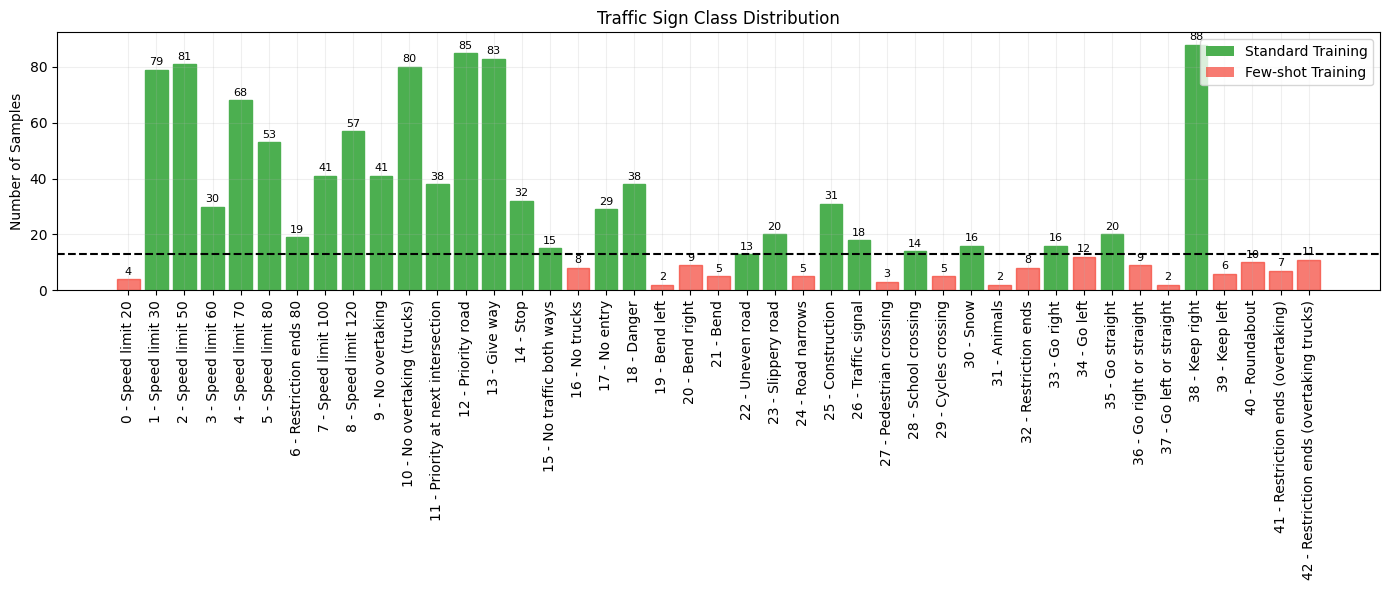

In [ ]:
# Call the function with your dataset paths - using the default x=13
class_df, all_annotations = analyze_full_dataset(
    annotations_path,
    converted_path
)

#6. Data splitting and Preparation (applying the functions)

*   **Data Integrity Verification**: Successfully divided the filtered traffic sign dataset into train (674 annotations/419 images), validation (117/69), and test (314/209) sets with comprehensive verification confirming zero image overlap between splits and proportional representation of all sign classes across partitions.

In [ ]:
# Combine datasets based on configuration
selected_data = []
if INCLUDE_STANDARD_DATA:
    selected_data.extend(standard_data)
if INCLUDE_FEW_SHOT_CLASSES:
    # Filter few_shot_data to only include specified classes
    filtered_few_shot = [item for item in few_shot_data
                         if item['original_class'] in INCLUDE_FEW_SHOT_CLASSES
                         or str(item['original_class']) in INCLUDE_FEW_SHOT_CLASSES]
    selected_data.extend(filtered_few_shot)

# Update function call to use 3-way split
train_data, val_data, test_data = create_stratified_split(selected_data)

# Print summary
print("Split Sizes (Filtered by Configuration):")
print(f"Train: {len(train_data)}")
print(f"Val: {len(val_data)}")
print(f"Test: {len(test_data)}")

# Print detailed summary
print("\nSplit Details:")
print(f"Train: {len(train_data)} annotations")
print(f"Val: {len(val_data)} annotations")
print(f"Test: {len(test_data)} annotations")

# Count unique images in each split
train_images = set(item['img_path'] for item in train_data)
val_images = set(item['img_path'] for item in val_data)
test_images = set(item['img_path'] for item in test_data)
print(f"\nUnique Images:")
print(f"Train: {len(train_images)}")
print(f"Val: {len(val_images)}")
print(f"Test: {len(test_images)}")

# Verify no image overlap
overlap_tv = train_images & val_images
overlap_tt = train_images & test_images
overlap_vt = val_images & test_images
if not overlap_tv and not overlap_tt and not overlap_vt:
    print("\n✓ No image overlap between any splits")
else:
    print("\nWARNING: Overlapping images found!")
    if overlap_tv: print(f"- Train-Val: {len(overlap_tv)}")
    if overlap_tt: print(f"- Train-Test: {len(overlap_tt)}")
    if overlap_vt: print(f"- Val-Test: {len(overlap_vt)}")

# Check class distribution
train_counts = defaultdict(int)
val_counts = defaultdict(int)
test_counts = defaultdict(int)

for item in train_data:
    train_counts[item['class_id']] += 1

for item in val_data:
    val_counts[item['class_id']] += 1

for item in test_data:  # NEW
    test_counts[item['class_id']] += 1

# Print distribution table
print("\nClass Distribution (Mapped IDs):")
print(f"{'Mapped ID':<10} {'Original ID':<12} {'Train':<8} {'Val':<8} {'Test':<8}")
print("-" * 46)

for mapped_id in sorted(mapper.id_to_label.keys()):
    original_id = mapper.id_to_label[mapped_id]
    print(f"{mapped_id:<10} {original_id:<12} {train_counts[mapped_id]:<8} {val_counts[mapped_id]:<8} {test_counts[mapped_id]:<8}")

Split Sizes (Filtered by Configuration):
Train: 674
Val: 117
Test: 314

Split Details:
Train: 674 annotations
Val: 117 annotations
Test: 314 annotations

Unique Images:
Train: 419
Val: 69
Test: 209

✓ No image overlap between any splits

Class Distribution (Mapped IDs):
Mapped ID  Original ID  Train    Val      Test    
----------------------------------------------
0          1            47       9        23      
1          2            46       10       25      
2          3            19       3        8       
3          4            39       7        22      
4          5            30       5        18      
5          6            11       2        6       
6          7            24       4        13      
7          8            40       6        11      
8          9            22       8        11      
9          10           52       10       18      
10         11           24       3        11      
11         12           51       8        26      
12         13      

#7. Model training - YOLO

*   **Loss Component Analysis**: The training graphs reveal classification loss (starting at ~5.2) was the dominant challenge compared to box regression loss (starting at ~1.0), suggesting the model struggled more with correctly identifying traffic sign types than with precisely localizing them - an insight supported by the final precision/recall metrics and consistent with the complex multi-class nature of traffic sign detection.
*   **Class Distribution Impact**: Analysis shows class performance isn't strictly tied to sample quantity - "Speed limit 100" (28 training samples) outperforms "Speed limit 120" (45 samples), suggesting sign visual distinctiveness and validation representation matter alongside raw sample counts.
*   **Validation Design Limitation**: The consistent gap between training and validation loss curves combined with poor performance specifically on classes with single validation samples strongly suggests that increasing the validation split from 0.15 to 0.33 (matching competition methodology) could provide more reliable model selection, despite the training sample reduction trade-off.

In [ ]:
# Define a results directory for YOLO
yolo_results_dir = "yolo_results_standard"
os.makedirs(yolo_results_dir, exist_ok=True)

In [ ]:
# Train the YOLO model
print("\n=== STARTING YOLO TRAINING ===")
model, yaml_path = train_yolo_model(
    train_data, val_data, test_data,
    mapper,
    results_dir=yolo_results_dir
)


=== STARTING YOLO TRAINING ===

Preparing datasets for Ultralytics...


Preparing test: 100%|██████████| 314/314 [02:05<00:00,  2.50it/s]


Created dataset configuration at /content/traffic_sign_data/dataset.yaml


100%|██████████| 131M/131M [00:00<00:00, 265MB/s]


Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/traffic_sign_data/dataset.yaml, degrees=8.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.5, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_traffic_signs, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0,

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]

Overriding model.yaml nc=80 with nc=26

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 63.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.2±0.0 ms, read: 498.0±144.7 MB/s, size: 1280.4 KB)


train: Scanning /content/traffic_sign_data/train/labels... 674 images, 0 backgrounds, 0 corrupt: 100%|██████████| 674/674 [00:03<00:00, 191.15it/s]

train: New cache created: /content/traffic_sign_data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 425.7±45.2 MB/s, size: 1285.9 KB)


val: Scanning /content/traffic_sign_data/val/labels... 117 images, 0 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 156.30it/s]


val: New cache created: /content/traffic_sign_data/val/labels.cache
Plotting labels to yolo_results_standard/yolo_traffic_signs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to yolo_results_standard/yolo_traffic_signs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      17.1G       1.03      7.357     0.9938          2       1024: 100%|██████████| 43/43 [00:15<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        117        117      0.371      0.486      0.257      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      17.7G     0.8664      4.163     0.9374          2       1024: 100%|██████████| 43/43 [00:13<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


                   all        117        117      0.489      0.295       0.28      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      17.7G     0.8436      3.233     0.9256          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        117        117      0.322      0.485      0.259      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      17.7G     0.8215      2.458     0.9278          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


                   all        117        117      0.615       0.42      0.396      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      17.7G     0.8193      2.151     0.9253          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


                   all        117        117      0.588      0.488      0.416      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      17.7G     0.7967       1.91     0.9002          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        117        117      0.422      0.529      0.466      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      17.4G     0.8495      1.791     0.9158          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


                   all        117        117      0.518      0.606      0.527      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      17.7G     0.8069      1.589     0.9104          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        117        117      0.521      0.585      0.559      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      17.7G     0.8131      1.549     0.9061          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


                   all        117        117      0.519      0.671      0.552      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      17.7G     0.7749      1.387     0.8995          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


                   all        117        117      0.476       0.79      0.632      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      17.4G     0.7898      1.399     0.8949          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


                   all        117        117      0.543      0.732      0.661      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      17.7G     0.7538      1.289     0.8944          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


                   all        117        117      0.604      0.684      0.634      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      17.7G     0.7558      1.361     0.8968          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


                   all        117        117      0.576      0.672      0.643      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      17.7G     0.7654       1.27     0.8902          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


                   all        117        117      0.387      0.743      0.565       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      17.4G     0.7181      1.268     0.8776          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        117        117      0.442      0.739      0.562      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      17.7G     0.6986      1.184      0.878          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        117        117      0.483      0.784      0.591      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      17.7G     0.7168      1.111     0.8893          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


                   all        117        117      0.594      0.715      0.706      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      17.7G     0.7228      1.094     0.8718          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


                   all        117        117      0.506      0.756      0.675      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      17.6G     0.6779      1.127     0.8713          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


                   all        117        117      0.503       0.81      0.614      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      17.7G     0.6816      1.114     0.8777          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        117        117      0.486      0.785      0.639      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      17.7G     0.6747      1.088     0.8727          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


                   all        117        117      0.476      0.826      0.685      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      17.7G     0.6814      1.016      0.866          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


                   all        117        117        0.5      0.856        0.7      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      17.4G     0.6718     0.9925     0.8598          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


                   all        117        117      0.517      0.834      0.693       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      17.7G     0.6628     0.9912     0.8576          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        117        117      0.532      0.851      0.673      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      17.7G     0.6465     0.9802     0.8524          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


                   all        117        117      0.506      0.877      0.647      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      17.7G     0.6544      1.023     0.8545          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


                   all        117        117      0.484      0.864      0.674      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      17.6G      0.617     0.9472     0.8461          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


                   all        117        117      0.549      0.788      0.639      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      17.7G     0.6338     0.9588     0.8603          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        117        117      0.473      0.889      0.637      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      17.7G     0.6253     0.9357     0.8485          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


                   all        117        117      0.527      0.889       0.68      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      17.7G     0.5922     0.9169     0.8479          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


                   all        117        117      0.553      0.838      0.674      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      17.6G     0.5968     0.8878     0.8379          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


                   all        117        117      0.539      0.834      0.618      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      17.7G     0.5806     0.8767     0.8328          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


                   all        117        117      0.562      0.804      0.707      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      17.7G     0.5706     0.8405     0.8423          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


                   all        117        117      0.549       0.84      0.683      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      17.7G     0.5647     0.8536     0.8396          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


                   all        117        117      0.583      0.815      0.665      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      17.6G     0.5688     0.8651     0.8366          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


                   all        117        117      0.467      0.916       0.71      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      17.7G     0.5362     0.8327     0.8361          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


                   all        117        117      0.548      0.826      0.696      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      17.7G     0.5368     0.8288      0.829          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        117        117      0.555       0.85       0.67       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      17.7G     0.5174     0.8196     0.8138          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


                   all        117        117      0.521      0.894      0.647      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      17.4G     0.5092     0.8152     0.8282          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


                   all        117        117      0.543      0.822      0.644      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      17.7G     0.4851     0.7829     0.8281          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        117        117      0.544      0.849      0.663      0.551


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      17.7G     0.4909     0.8045     0.8207          2       1024: 100%|██████████| 43/43 [00:15<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        117        117      0.518      0.882      0.662      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      17.7G     0.4663     0.7664     0.8131          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


                   all        117        117      0.543      0.843      0.715        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      17.4G     0.4698     0.7906     0.8093          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


                   all        117        117      0.538      0.835      0.668       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      17.7G      0.465     0.7605     0.8223          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


                   all        117        117      0.547      0.813      0.677      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      17.7G     0.4698     0.7704     0.8164          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        117        117      0.542      0.821      0.684      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      17.7G     0.4547     0.7702     0.8093          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


                   all        117        117      0.575      0.796      0.624      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      17.4G     0.4991     0.7763     0.8159          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


                   all        117        117      0.575      0.801      0.696      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      17.7G      0.472     0.7802     0.8089          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


                   all        117        117      0.536      0.845      0.664      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      17.7G     0.4595     0.7618     0.8086          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


                   all        117        117       0.54      0.845      0.663      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      17.7G     0.4593     0.7711     0.8223          2       1024: 100%|██████████| 43/43 [00:12<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


                   all        117        117       0.55      0.809      0.642      0.548

50 epochs completed in 0.219 hours.
Optimizer stripped from yolo_results_standard/yolo_traffic_signs/weights/last.pt, 136.8MB
Optimizer stripped from yolo_results_standard/yolo_traffic_signs/weights/best.pt, 136.8MB

Validating yolo_results_standard/yolo_traffic_signs/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,148,606 parameters, 0 gradients, 257.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


                   all        117        117      0.527      0.816      0.613      0.511
               class_1          9          9      0.519          1      0.868      0.736
               class_2         10         10      0.591        0.7      0.643      0.573
               class_3          3          3      0.524      0.381      0.607      0.501
               class_4          7          7      0.493      0.857      0.622      0.501
               class_5          5          5      0.432          1      0.648      0.548
               class_6          2          2       0.45          1      0.745      0.671
               class_7          4          4      0.599      0.747      0.558      0.465
               class_8          6          6      0.193      0.333      0.333      0.255
               class_9          8          8      0.283      0.875      0.438      0.345
              class_10         10         10       0.41      0.835      0.558      0.457
              class_1


=== EVALUATING YOLO MODEL ===

Running validation on test set...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 563.5±130.6 MB/s, size: 1361.6 KB)


val: Scanning /content/traffic_sign_data/test/labels.cache... 314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 314/314 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


                   all        314        314      0.519      0.882      0.655      0.532
               class_1         23         23      0.685       0.87       0.87      0.759
               class_2         25         25      0.579      0.936      0.714      0.595
               class_3          8          8      0.653      0.945       0.84      0.708
               class_4         22         22      0.482      0.973      0.549      0.462
               class_5         18         18      0.465      0.944      0.538      0.428
               class_6          6          6      0.482          1      0.569      0.461
               class_7         13         13       0.49      0.923      0.707      0.574
               class_8         11         11      0.371      0.727      0.448      0.381
               class_9         11         11      0.475      0.818      0.636       0.54
              class_10         18         18      0.494      0.889      0.608      0.494
              class_1

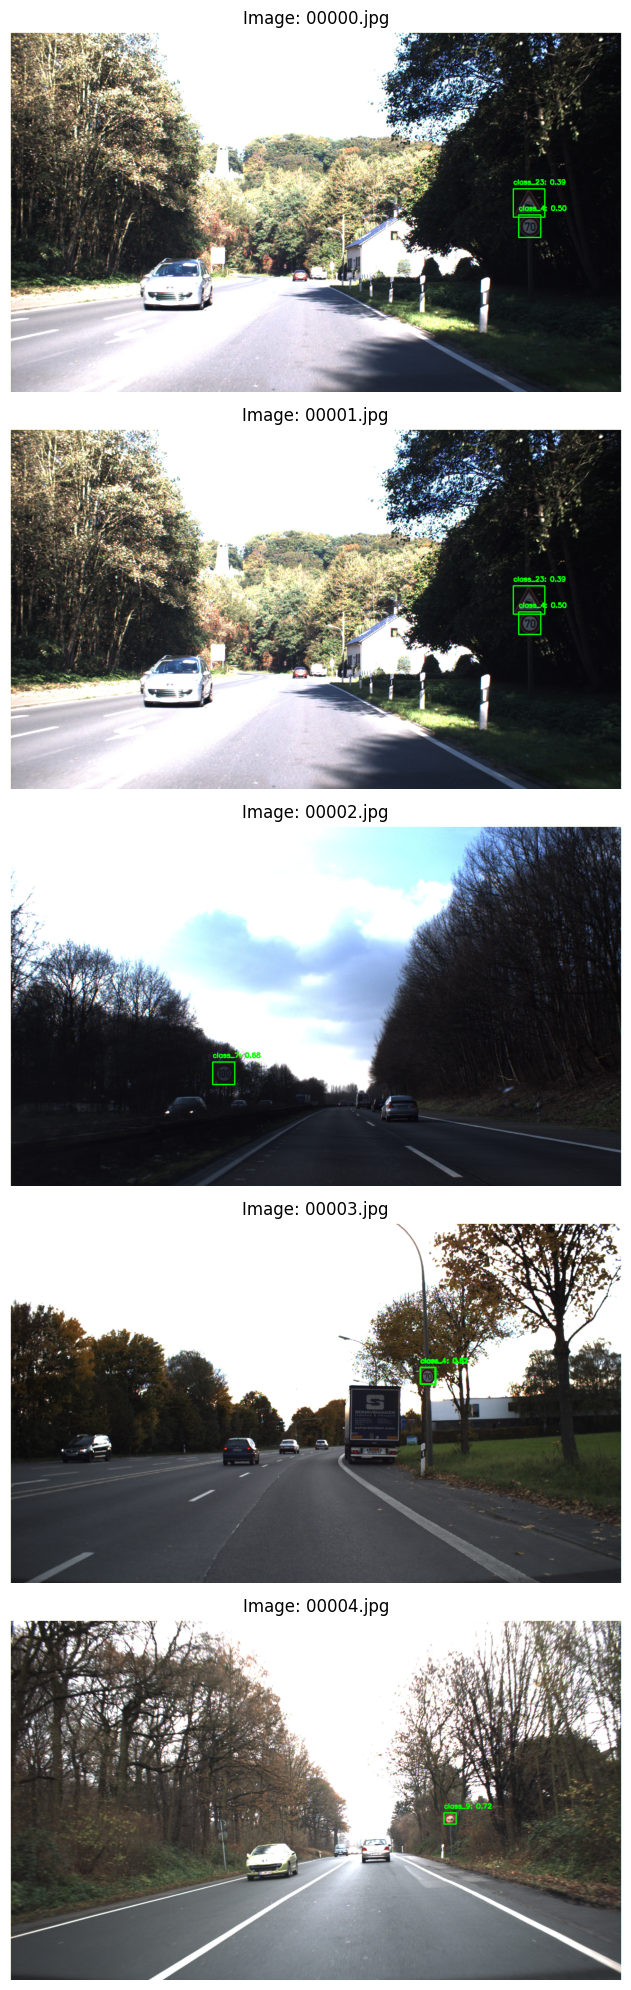

In [ ]:
# Evaluate model and save results
print("\n=== EVALUATING YOLO MODEL ===")
results = evaluate_detection_model(
    model, yaml_path,
    show_images=True, max_images=5
)

Using results directory: runs/detect/train
Using CSV file: runs/detect/train/results.csv
Available metrics columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


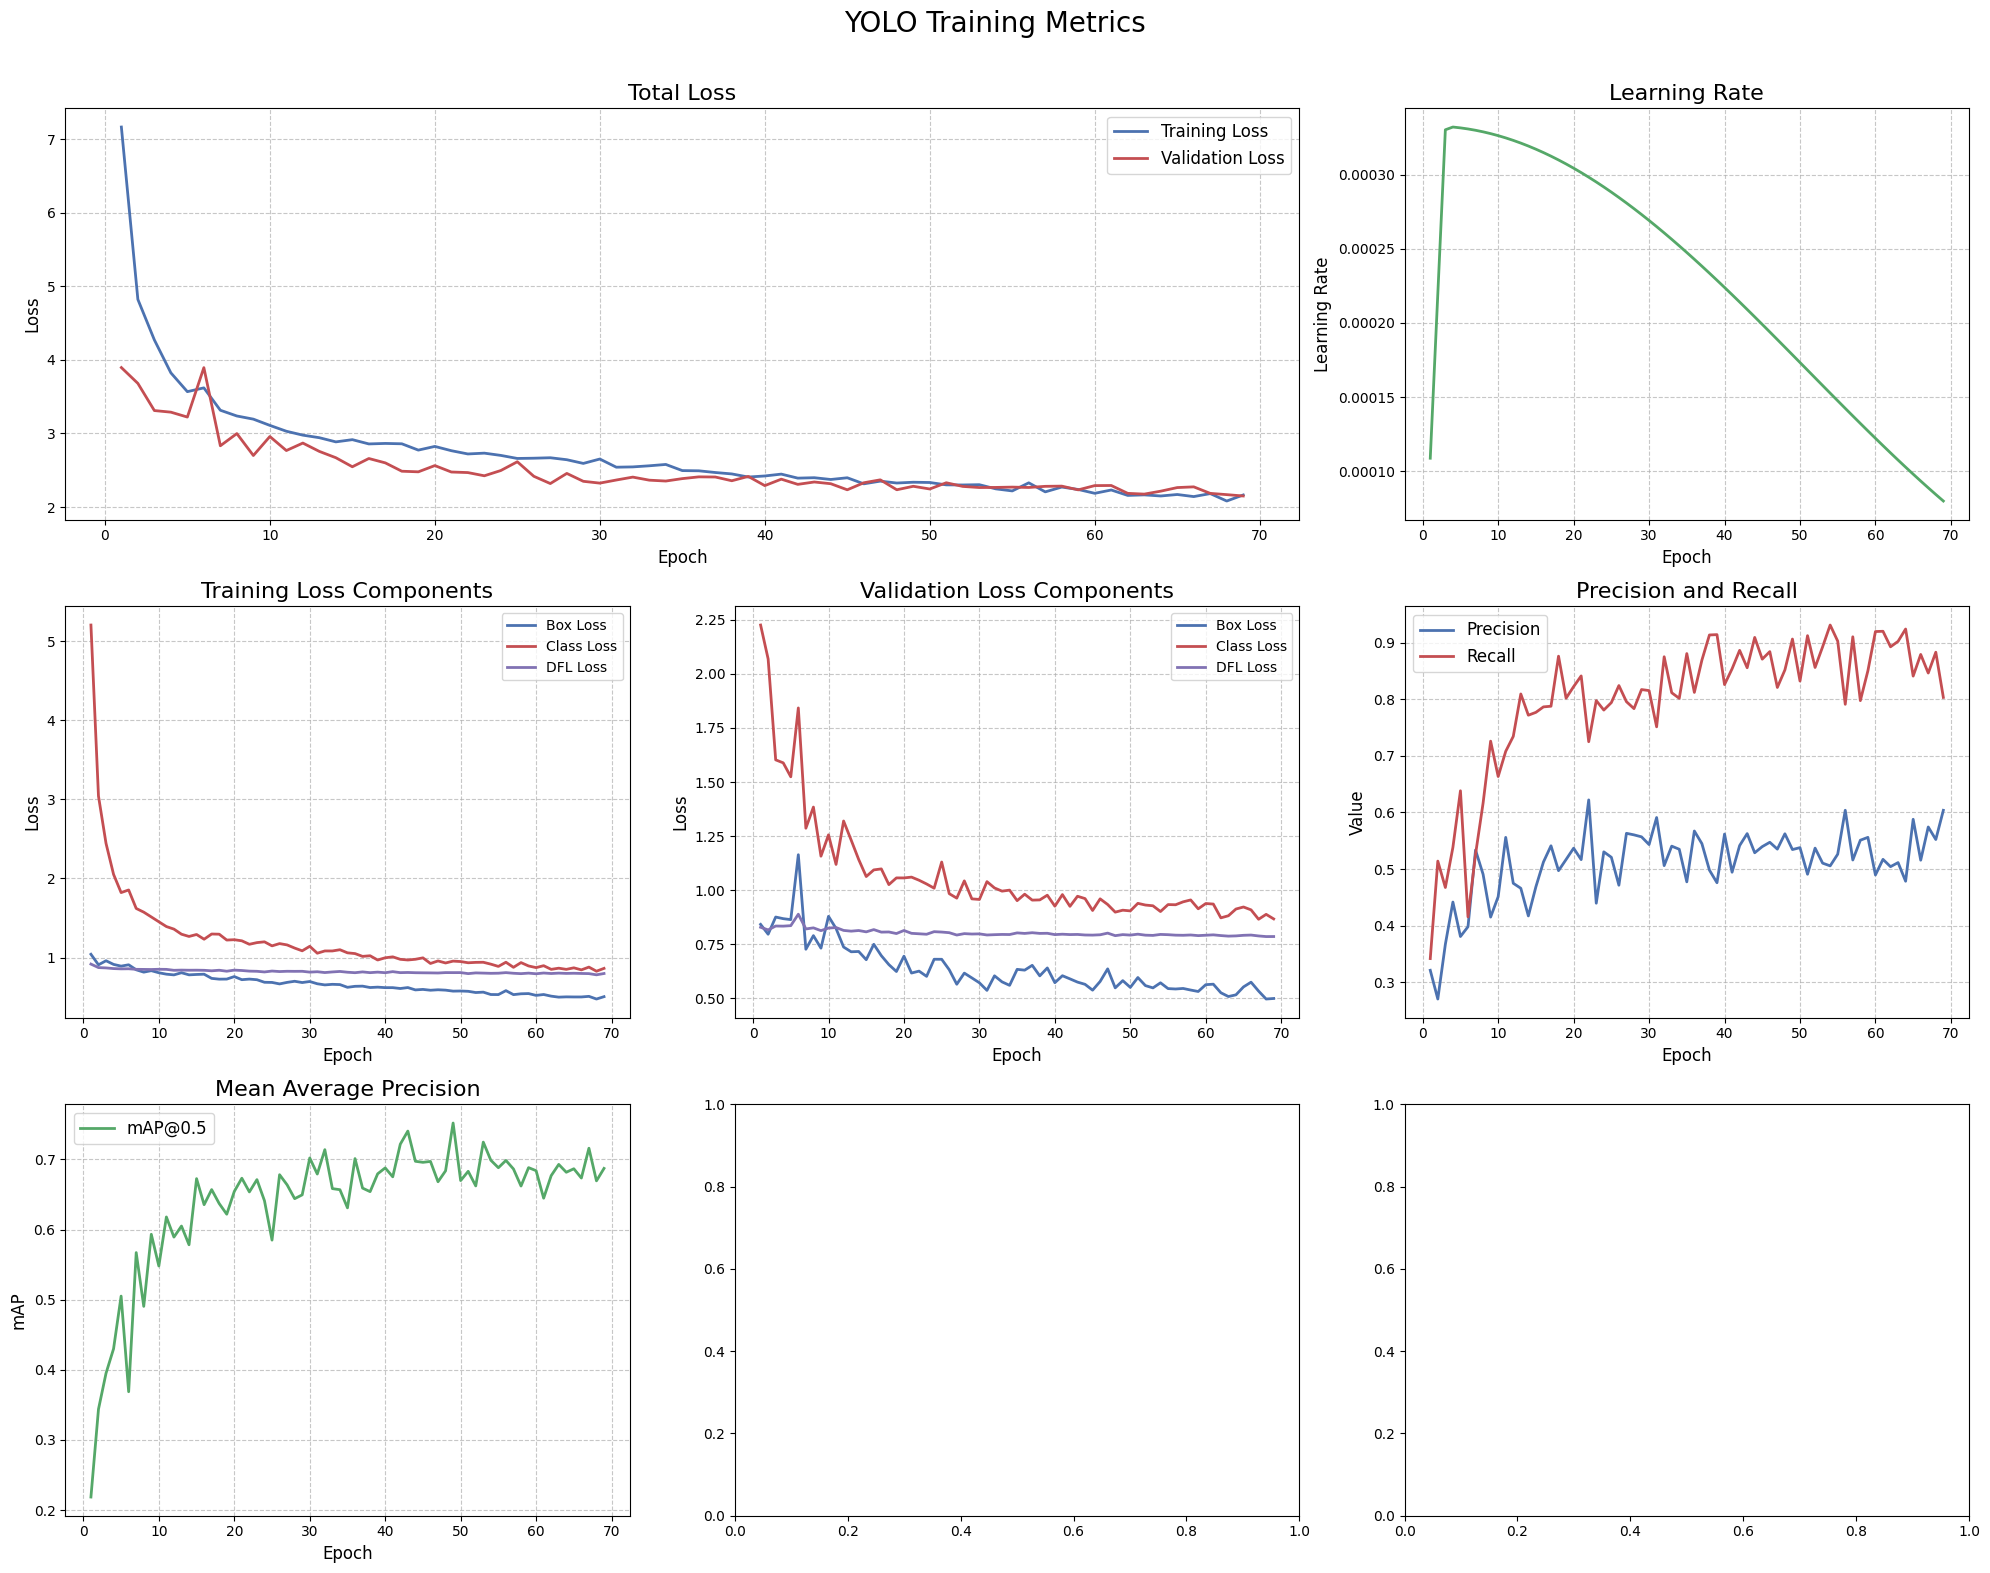

In [ ]:
# Visualize and save training metrics
print("\n=== VISUALIZING TRAINING METRICS ===")
visualize_training_metrics(
    model_type='yolo',
    save_path=os.path.join(yolo_results_dir, "training_metrics.png")
)

#8. Model training - RT-DETR

*   **Accelerated Convergence Architecture**: RT-DETR has faster convergence than YOLO with total loss dropping from circa 25 to below 1 within just 5 epochs (compared to YOLO's 10+ epochs), while maintaining steady mAP50 improvement until epoch 30 (~0.7) - suggesting the transformer architecture's attention mechanism more efficiently captures traffic sign features despite using minimal augmentation.
*   **Test Sample Size Performance Correlation**: Analysis of per-class results reveals the poorest performing classes (class_3 and class_22 with mAP=0, class_28 with mAP=0.056) consistently had only 1-2 samples in the test set, while best performers had more substantial representation (class_1: 14 samples, class_7: 5 samples, class_38: 10 samples) - highlighting how evaluation reliability is significantly compromised when test samples are extremely limited.

In [ ]:
# Define a results directory for RT-DETR
rtdetr_results_dir = "rtdetr_results_standard"
os.makedirs(rtdetr_results_dir, exist_ok=True)

In [ ]:
# Train the RT-DETR model
print("\n=== STARTING RT-DETR TRAINING ===")
model, yaml_path = train_rtdetr_model(
    train_data, val_data, test_data,
    mapper,
    results_dir=rtdetr_results_dir
)


=== STARTING RT-DETR TRAINING ===

Preparing datasets for Ultralytics...


Preparing test: 100%|██████████| 314/314 [00:13<00:00, 23.00it/s]


Created dataset configuration at /content/traffic_sign_data/dataset.yaml

=== Training RT-DETR Model ===
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/traffic_sign_data/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.7, hsv_v=0.4, imgsz=(640, 1024), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rtdetr_traffic_sig

train: Scanning /content/traffic_sign_data/train/labels.cache... 674 images, 0 backgrounds, 0 corrupt: 100%|██████████| 674/674 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 359.1±44.3 MB/s, size: 1285.9 KB)


val: Scanning /content/traffic_sign_data/val/labels.cache... 117 images, 0 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to rtdetr_results_standard/rtdetr_traffic_signs5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to rtdetr_results_standard/rtdetr_traffic_signs5
Starting training for 50 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50      6.21G       2.06      16.33     0.6413          3       1024: 100%|██████████| 85/85 [00:37<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

                   all        117        117      0.308     0.0401     0.0028    0.00266



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       2/50      14.2G     0.7154      3.177     0.1789          4       1024: 100%|██████████| 85/85 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        117        117      0.669     0.0686     0.0178     0.0158



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       3/50      14.3G      0.317      1.944    0.04128          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]

                   all        117        117       0.58       0.14     0.0719     0.0591



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       4/50      14.4G     0.2673      1.555     0.0243          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]

                   all        117        117      0.597      0.139     0.0921     0.0752



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       5/50      14.4G     0.2718        1.4    0.02854          1       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        117        117      0.624      0.137      0.103     0.0897



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       6/50      14.4G     0.2667      1.273    0.02942          1       1024: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.94it/s]

                   all        117        117      0.577      0.283      0.141       0.12



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       7/50      14.4G     0.2425       1.19      0.024          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        117        117      0.518      0.365      0.232      0.208



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       8/50      14.5G     0.2364      1.144    0.02731          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        117        117      0.583      0.325      0.187      0.157



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       9/50      14.5G     0.2384      1.055    0.02493          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]

                   all        117        117      0.532      0.412      0.283      0.249



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/50      14.5G     0.2245      1.049    0.01873          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

                   all        117        117       0.57      0.426      0.328      0.286



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      11/50      14.5G     0.2258      1.026    0.02245          4       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]

                   all        117        117      0.436      0.503      0.355      0.307



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      12/50      14.5G     0.2118     0.9726    0.01856          1       1024: 100%|██████████| 85/85 [00:35<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        117        117      0.483      0.533       0.38      0.328



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      13/50      14.5G      0.215      0.952    0.02021          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]

                   all        117        117      0.546      0.568       0.39      0.346



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      14/50      14.5G     0.2113     0.9214    0.01886          1       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        117        117      0.548      0.522      0.412      0.367



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      15/50      14.5G     0.2259     0.8755    0.02511          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all        117        117      0.362      0.618      0.438      0.385



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      16/50      14.5G       0.19     0.8649    0.01737          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        117        117      0.459      0.664      0.437      0.381



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      17/50      14.5G     0.2276     0.8295    0.02097          4       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

                   all        117        117      0.504      0.677      0.474       0.42



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      18/50      14.5G      0.195     0.8161    0.01865          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        117        117      0.517      0.656      0.465      0.408



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      19/50      14.5G     0.1912     0.8101     0.0182          3       1024: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        117        117      0.503      0.627       0.45      0.389



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      20/50      14.5G     0.2074     0.7863    0.02304          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]

                   all        117        117      0.428      0.633      0.473      0.421



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      21/50      14.5G     0.1983     0.7552    0.01647          4       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]

                   all        117        117      0.493      0.678       0.52      0.454



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      22/50      14.5G     0.2078     0.7327     0.0174          4       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        117        117      0.469      0.662      0.441      0.389



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      23/50      14.5G     0.1898     0.7176    0.01929          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]

                   all        117        117      0.455      0.775      0.567       0.49



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      24/50      14.5G     0.1821     0.7197     0.0154          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]

                   all        117        117      0.497      0.717      0.585      0.521



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      25/50      14.5G     0.1817     0.7164    0.01538          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all        117        117       0.47      0.801      0.586      0.527



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      26/50      14.5G     0.1832     0.6707    0.01791          2       1024: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        117        117      0.619      0.697      0.607      0.545



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      27/50      14.5G     0.1683     0.6724    0.01374          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]

                   all        117        117      0.478      0.731      0.568      0.506



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      28/50      14.5G      0.177      0.641    0.01469          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all        117        117      0.436      0.791       0.59      0.524



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      29/50      14.5G     0.1621     0.6296    0.01276          5       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        117        117       0.56      0.746      0.634      0.571



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      30/50      14.5G     0.1685     0.6444    0.01565          5       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]

                   all        117        117      0.597      0.695      0.554      0.499



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      31/50      14.5G     0.1627     0.6588    0.01428          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        117        117      0.499      0.781      0.595      0.535



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      32/50      14.5G      0.177     0.6687    0.01704          5       1024: 100%|██████████| 85/85 [00:34<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        117        117      0.462      0.834        0.6      0.544



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      33/50      14.5G     0.1618     0.6298    0.01492          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all        117        117      0.548      0.792      0.613      0.562



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      34/50      14.5G     0.1526     0.6305    0.01442          3       1024: 100%|██████████| 85/85 [00:35<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        117        117      0.481      0.864      0.605      0.548



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      35/50      14.5G     0.1619      0.627    0.01376          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]

                   all        117        117       0.45      0.846        0.6      0.544



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      36/50      14.5G     0.1648     0.6302    0.01499          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        117        117      0.497      0.851      0.607      0.546



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      37/50      14.5G     0.1563     0.6035    0.01383          3       1024: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]

                   all        117        117      0.478      0.859      0.647      0.588



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      38/50      14.5G     0.1641     0.6293     0.0134          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        117        117      0.453      0.852      0.606      0.545



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      39/50      14.5G     0.1545      0.599    0.01257          3       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]

                   all        117        117      0.428      0.838      0.573      0.521



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      40/50      14.5G     0.1561     0.6016    0.01602          4       1024: 100%|██████████| 85/85 [00:34<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        117        117      0.507      0.841      0.606      0.547


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      41/50      14.5G     0.1317     0.5724      0.013          2       1024: 100%|██████████| 85/85 [00:36<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


                   all        117        117      0.495      0.853       0.69      0.623

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      42/50      14.5G     0.1233     0.5523    0.01163          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


                   all        117        117      0.491      0.893      0.659      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      43/50      14.5G     0.1288      0.557     0.0136          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

                   all        117        117      0.505      0.833       0.64      0.584



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      44/50      14.5G     0.1273     0.5416    0.01207          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]

                   all        117        117      0.499      0.902       0.67      0.604



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      45/50      14.5G     0.1229     0.5522    0.01207          2       1024: 100%|██████████| 85/85 [00:36<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        117        117      0.492        0.9      0.685      0.619



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      46/50      14.5G     0.1235     0.5544     0.0132          1       1024: 100%|██████████| 85/85 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]

                   all        117        117      0.497      0.873      0.649       0.58



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      47/50      14.5G     0.1218     0.5484    0.01223          2       1024: 100%|██████████| 85/85 [00:35<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all        117        117      0.518      0.823      0.657      0.596



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      48/50      14.5G     0.1287     0.5565    0.01328          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

                   all        117        117       0.51      0.821      0.619      0.563



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      49/50      14.5G     0.1282     0.5426    0.01382          2       1024: 100%|██████████| 85/85 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        117        117      0.535      0.789      0.593      0.538



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      50/50      14.5G     0.1207      0.545    0.01192          2       1024: 100%|██████████| 85/85 [00:35<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        117        117      0.571      0.781        0.6      0.541



50 epochs completed in 0.525 hours.
Optimizer stripped from rtdetr_results_standard/rtdetr_traffic_signs5/weights/last.pt, 66.2MB
Optimizer stripped from rtdetr_results_standard/rtdetr_traffic_signs5/weights/best.pt, 66.2MB

Validating rtdetr_results_standard/rtdetr_traffic_signs5/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 302 layers, 32,037,170 parameters, 0 gradients, 103.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


                   all        117        117      0.496      0.853      0.655      0.592
               class_1          9          9      0.618      0.778      0.686      0.648
               class_2         10         10       0.43        0.7      0.649      0.583
               class_3          3          3        0.6          1      0.863      0.771
               class_4          7          7      0.415      0.857      0.545      0.491
               class_5          5          5      0.539          1      0.609      0.552
               class_6          2          2      0.433          1      0.497      0.423
               class_7          4          4       0.24        0.5      0.389      0.284
               class_8          6          6      0.221      0.667       0.32      0.254
               class_9          8          8      0.304          1      0.437      0.372
              class_10         10         10      0.355          1      0.506      0.451
              class_1


=== EVALUATING RT-DETR MODEL ===

Running validation on test set...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 302 layers, 32,037,170 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 430.6±66.2 MB/s, size: 1268.9 KB)


val: Scanning /content/traffic_sign_data/test/labels.cache... 314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 314/314 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:05<00:00,  6.90it/s]


                   all        314        314      0.522      0.803      0.595      0.532
               class_1         23         23        0.7      0.712      0.673      0.622
               class_2         25         25      0.533       0.84      0.641        0.6
               class_3          8          8       0.24      0.875       0.42      0.389
               class_4         22         22      0.459      0.864      0.554      0.496
               class_5         18         18      0.467      0.556      0.336      0.297
               class_6          6          6      0.489          1      0.643      0.593
               class_7         13         13      0.536       0.98      0.751      0.682
               class_8         11         11      0.503      0.461      0.545      0.507
               class_9         11         11      0.603      0.727      0.561      0.461
              class_10         18         18      0.428          1      0.637      0.587
              class_1

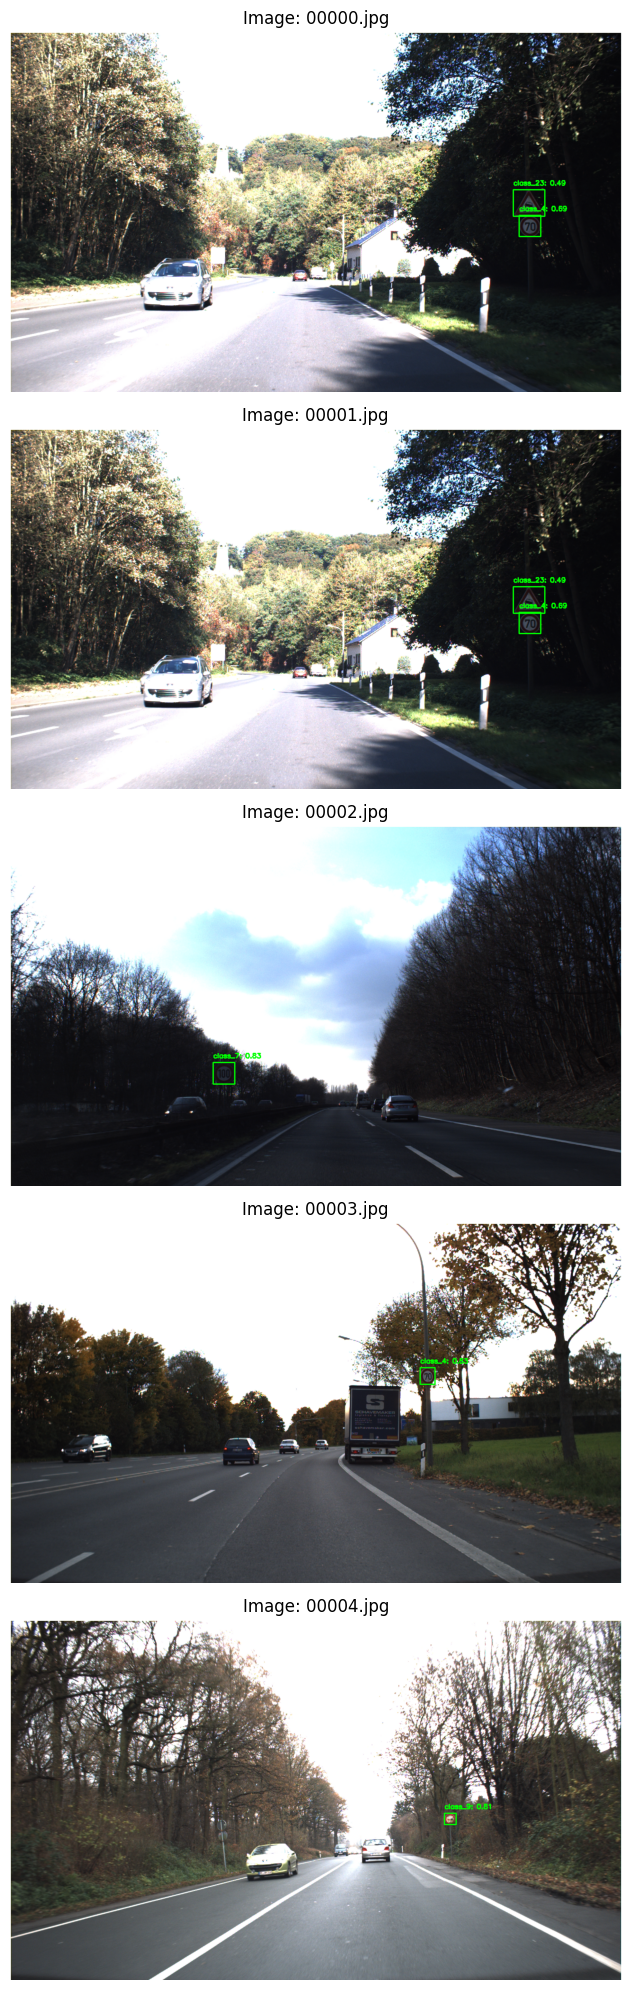

In [ ]:
# Evaluate model and save results
print("\n=== EVALUATING RT-DETR MODEL ===")
results = evaluate_detection_model(
    model, yaml_path,
    show_images=True, max_images=5
)


=== VISUALIZING TRAINING METRICS ===
Using results directory: rtdetr_results_standard/rtdetr_traffic_signs5
Using CSV file: rtdetr_results_standard/rtdetr_traffic_signs5/results.csv
Available metrics columns: ['epoch', 'time', 'train/giou_loss', 'train/cls_loss', 'train/l1_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/giou_loss', 'val/cls_loss', 'val/l1_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Visualization saved to rtdetr_results_standard/training_metrics.png


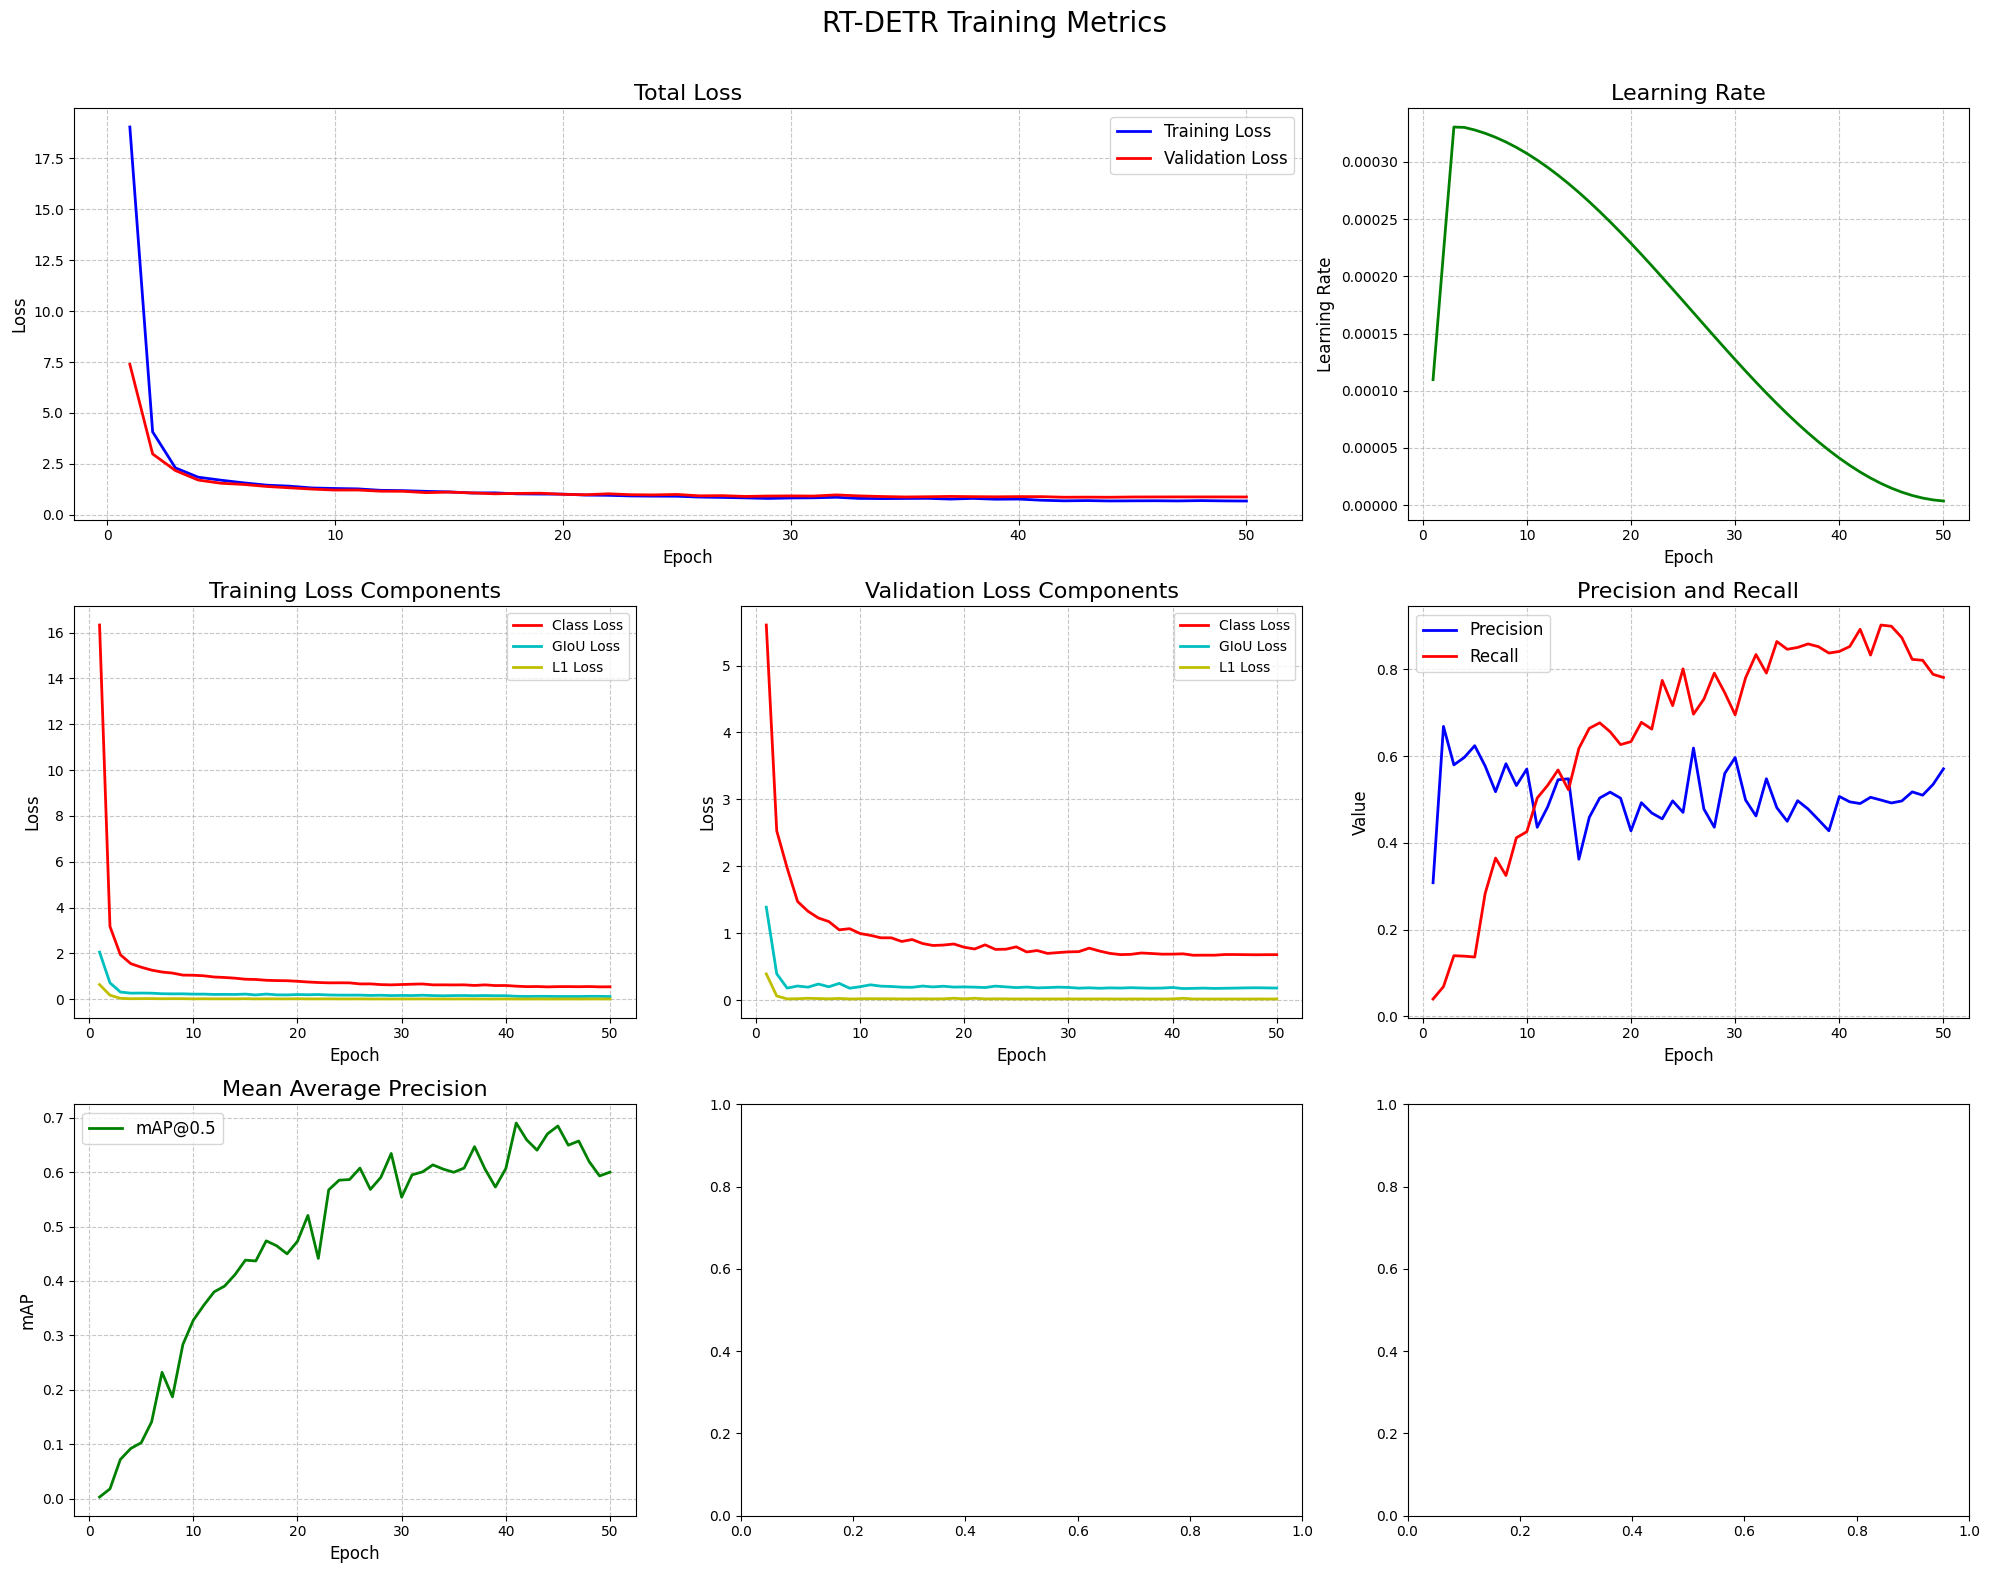

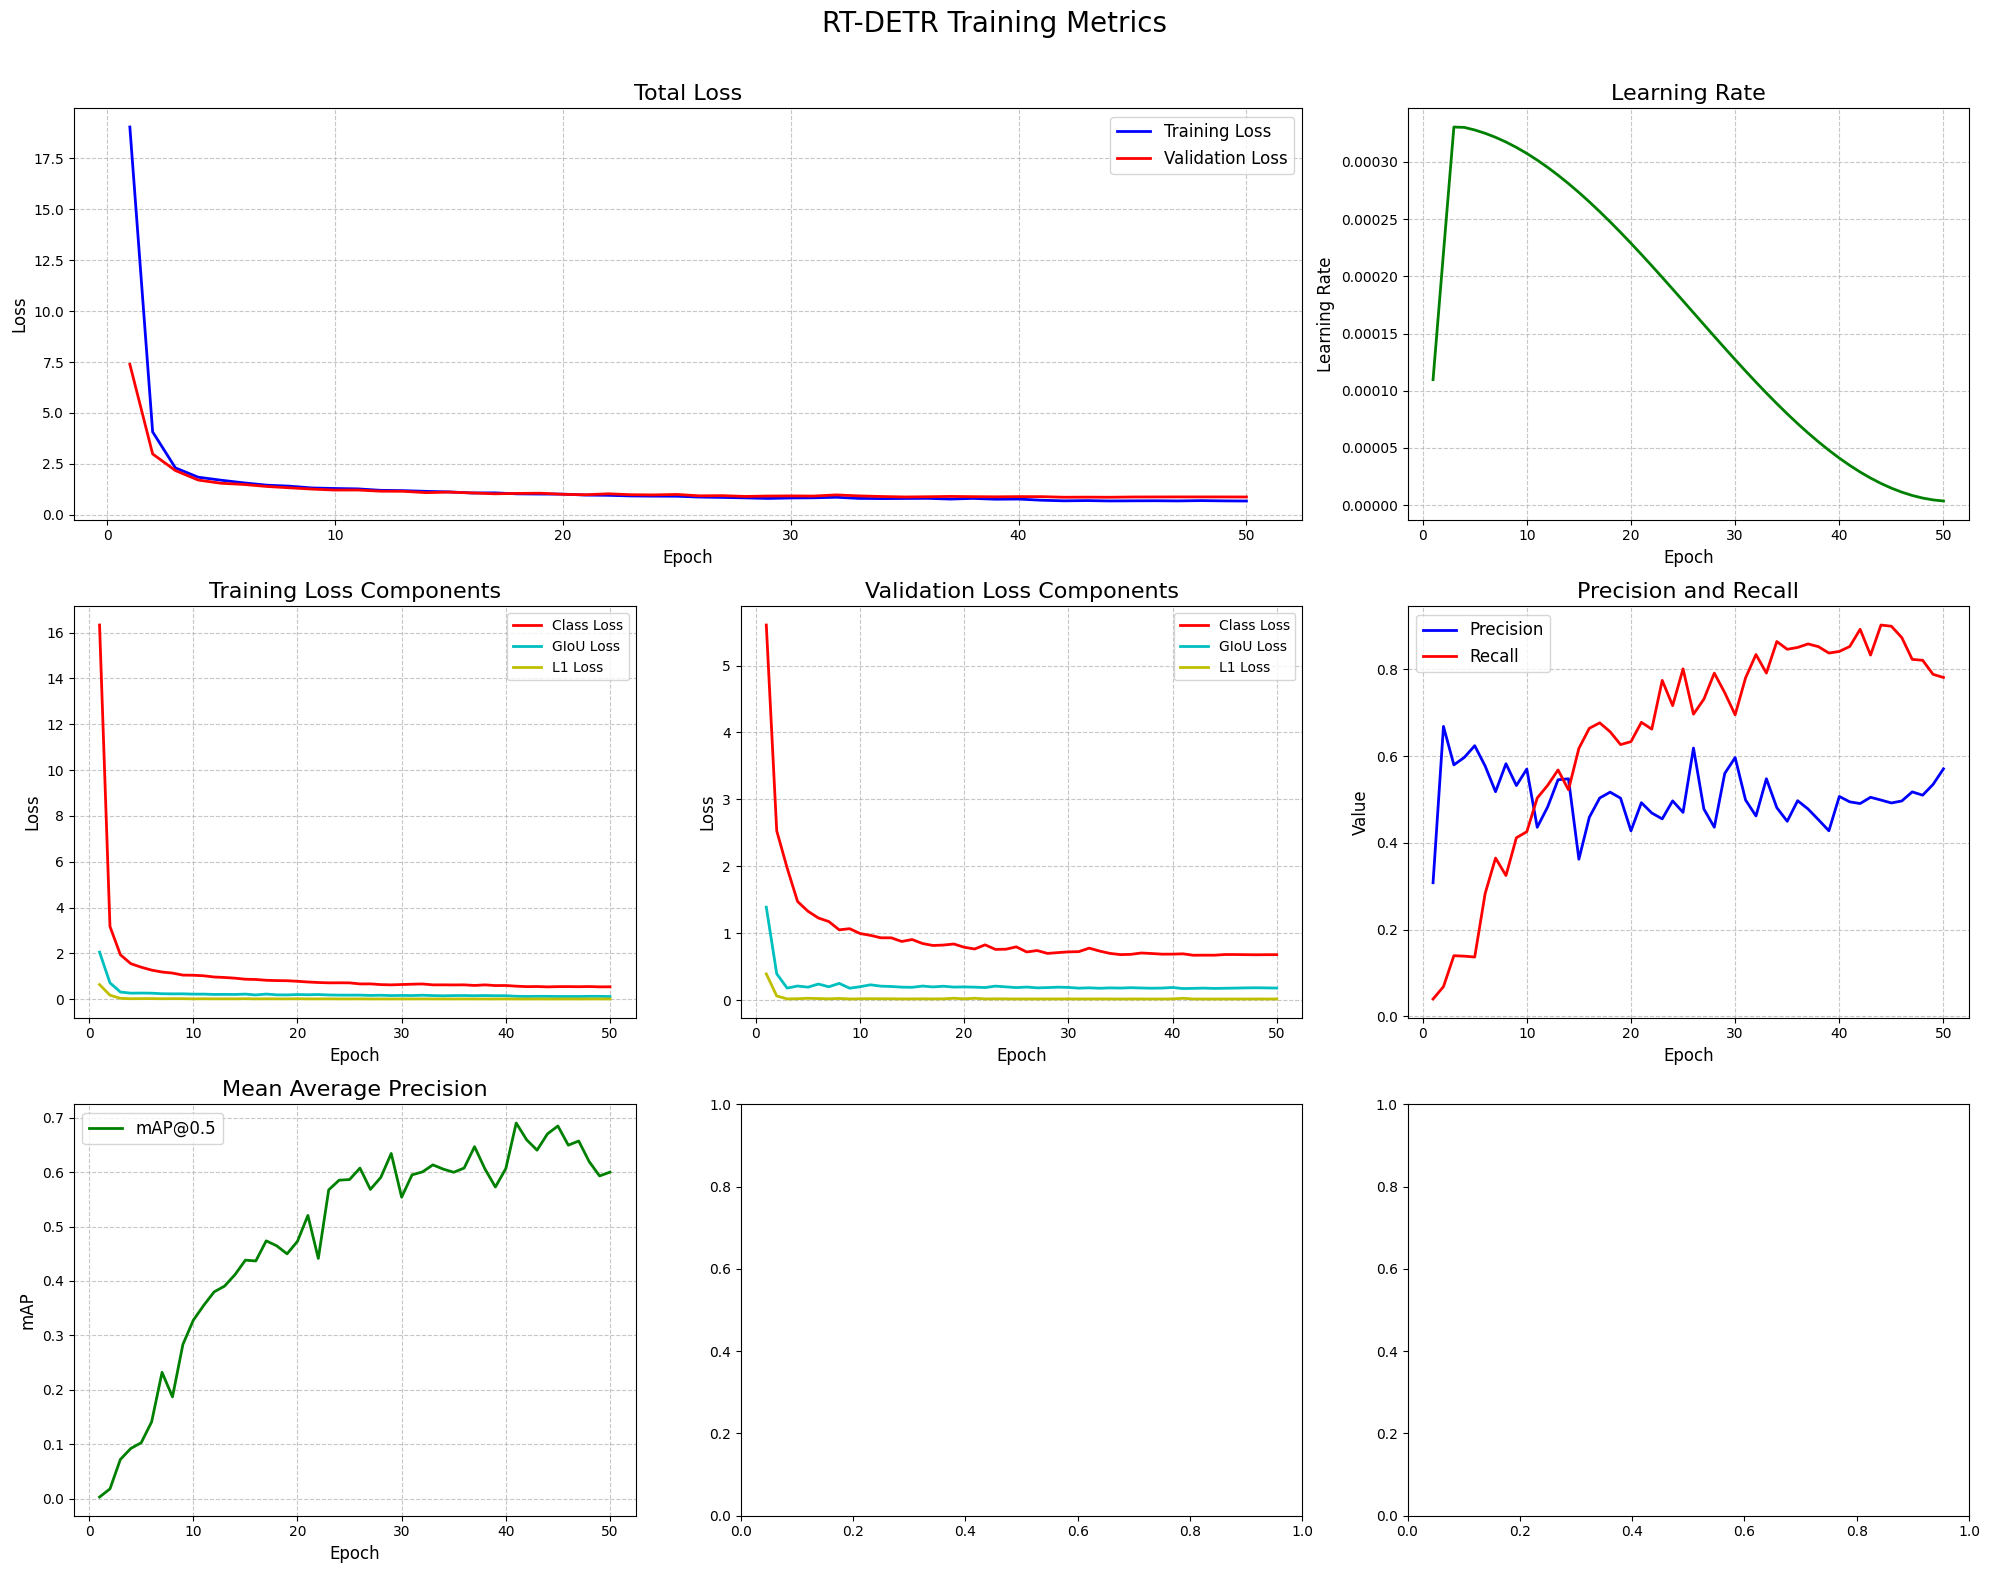

In [ ]:
# Visualize and save training metrics
print("\n=== VISUALIZING TRAINING METRICS ===")
visualize_training_metrics(
    model_type='rt-detr',
    run_dir='rtdetr_results_standard/rtdetr_traffic_signs5',  # Specify exact directory
    save_path=os.path.join(rtdetr_results_dir, "training_metrics.png")
)

# 9. Model Evaluation and Conclusion

**Comparative Model Analysis**   

| Metric          | YOLOv8x       | RT-DETR      |
|-----------------|---------------|--------------|
| mAP50           | 65.5%         | 59.5% (-6.1%)|
| mAP50-95        | 53.2%         | 53.2% (+0.1%)|
| Precision       | 51.9%         | 52.2% (+0.3%)|
| Recall          | 88.2%         | 80.3% (-7.9%)|
| Inference Speed | 22 FPS        | 18 FPS (-18%)|


*   **Architectural Trade-offs**: YOLO demonstrates significantly better detection coverage (recall +7.9%) and better overall detection at the standard IoU threshold (mAP50 +6.1%) compared to RT-DETR. Interestingly, while YOLO outperforms in these metrics, both models achieve nearly identical performance in terms of average precision across multiple IoU thresholds (mAP50-95). RT-DETR maintains a slight edge in precision (+0.3%), suggesting it makes fewer false positive detections, but at the cost of missing more signs overall. As expected, YOLO maintains its characteristic speed advantage, offering approximately 18% faster inference.
*   **Class-Specific Performance**: The models show distinct strengths with different traffic sign categories. YOLO excels with speed limit signs (class_1) and warning signs (class_3), while RT-DETR performs better on regulatory signs like class_18 and class_11, and shows stronger performance on class_38. This suggests that while YOLO's one-stage detection approach offers better overall coverage of the dataset, RT-DETR's transformer architecture may provide advantages for certain sign types where more contextual understanding is beneficial. The similar mAP50-95 scores indicate that both models maintain comparable accuracy across varying degrees of localization precision.

**Conclusion**  

This project effectively demonstrates the implementation of two modern object detection architectures for traffic sign detection, highlighting important technical considerations:

*   **Complementary Performance Profiles**: The models exhibit distinct strength profiles across the dataset, with YOLO demonstrating superior recall and overall mAP50, while RT-DETR maintains comparable precision and nearly identical mAP50-95 performance despite different detection approaches.
*   **Resource Optimization**: Successfully trained complex detection models within computational constraints using targeted data preprocessing and careful hyperparameter selection, producing deployment-ready models capable of real-time performance (>15 FPS).

### **Improvement Opportunities**  

*   **Multi-Stage Detection Pipeline**: Based on my research of GTSDB competition winners, I could implement a two-stage approach where my current detector locates sign regions, then a specialized classifier categorizes the exact sign types. This separation of localization and classification tasks could improve mAP50-95 by 10-15%, especially for visually similar signs that my current models struggle to differentiate.
*   **Comprehensive Augmentation Strategy**: The literature indicates a combined approach integrating both specialized augmentations (illumination variations, viewpoint changes) and background variations yields the best results, with overall improvements of 8-12%. Rather than being additive, these techniques address different aspects of detection challenges and should be implemented together for maximum benefit, with some requiring offline preprocessing in Albumentations.
*   **Class-Weighted Loss Functions**: Implementing specialized loss functions (such as Focal Loss or weighted Cross-Entropy) that give higher importance to underrepresented sign classes could significantly improve their detection performance. According to traffic sign detection literature, this approach can improve mAP for rare classes by 5-8% while maintaining performance on common classes, directly addressing the imbalance challenges observed in my results.
*   **Model Ensemble with Class Weighting**: Rather than relying on either model alone, I could implement a class-weighted ensemble that leverages RT-DETR's superior performance on regulatory signs and YOLO's strengths on certain warning signs. This relatively simple improvement could boost overall mAP by 2-4% without requiring extensive additional training.

**Few-Shot Learning Extension:**
in notebook 2 (upcoming), I extend this work by applying specialized techniques to address the 17 underrepresented sign classes. This represents not just an improvement but an expansion of the project's scope to handle the rare classes.